# **Case Study - Customers' Default Payments in Taiwan**
## **For Sr. Decision Scientist Interview**
## **Operations Decision Science**

Hi, I am Gayane. Thank you for your time to review my notebook.


This notebook presents the case study analysis accompanied by interpretations of all outputs. The document is structured in a sequential manner, includes data exploration, modeling procedures, and interpretability results.

**Setting Up the Libraries and Data**

**Deliverable 1: Exploratory Data Analysis**
* Explore the dataset and understand each variable
* Identify missing values and perform necessary cleaning
* Generate descriptive statistics to summarize trends
* Univariate (Histograms, Boxplots), Bivariate (Pairplot), Correlations

**Deliverable 2: Model Development**
* Tree-Based Models ( Random Forest, XGBoost, LightGBM, CatBoost )
* Other models: Support Vector Machine (SVM), Naive Bayes Classifier, Multi-Layer Perceptron (MLP) Classifier, Feedforward Neural Network (Keras Model)
* Handling Imbalanced Data with SMOTE
* Feature Selection Methods (RFE, LASSO)
* XAI Methods for Model Interpretation (SHAP, LIME, Permutation Importance)


# **Setting Up the Libraries and Data**

In [1]:
!pip install ucimlrepo # this allows us to access the data
!pip install xgboost lightgbm catboost
!pip install shap lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e665e242536db48e2380a60f9493bee171156c7883a7cb847b7a5e5e88fe75b9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
# Please make sure to run these library imports first.

# ============================================
# Core Libraries
# ============================================
import os
import gc
import random
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap
pd.set_option('display.max_columns', 100)

# ============================================
# Visualization
# ============================================
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

# ============================================
# Scikit-Learn: Preprocessing, Modeling, Evaluation
# ============================================
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE

# ============================================
# Gradient Boosting Libraries
# ============================================
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# ============================================
# Imbalanced Data Handling
# ============================================
from imblearn.over_sampling import SMOTE

# ============================================
# Explainable AI
# ============================================
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

# ============================================
# Deep Learning (TensorFlow / Keras)
# ============================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [3]:
# 1: Data Loading
# ----------------------------------------------------
# ----------------------------------------------------

from ucimlrepo import fetch_ucirepo

# Fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# Features and target
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# Let’s replace those X1, X2 placeholders with the real column names from the
# dataset description so it’s clearer what each variable represents.
column_names = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

X.columns = column_names

# Create a new DataFrame df and combine features and target
df = X.copy()
df['default_payment_next_month'] = y

# View the DataFrame
df.head()


LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   default_payment_next_month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

In [4]:
# metadata
print(default_of_credit_card_clients.metadata)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

## Variable Description

| **Category** | **Variable** | **Description** |
|---------------|----------------|-----------------|
| **Demographic & Personal Information** | `SEX`, `EDUCATION`, `MARRIAGE`, `AGE` | Gender, education level, marital status, and age in years |
| **Credit & Financial Limit** | `LIMIT_BAL` | Amount of given credit (NT dollars; includes individual and family/supplementary credit) |
| **Payment Status History** | `PAY_0`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5`, `PAY_6` | Repayment status for April–September 2005 (*-1 = paid duly; 0 = use of revolving credit; 1–9 = months delayed*) |
| **Bill Statement Amounts** | `BILL_AMT1`–`BILL_AMT6` | Amount of bill statement for April–September 2005 (NT dollars) |
| **Payment Amount History** | `PAY_AMT1`–`PAY_AMT6` | Amount of previous payment for April–September 2005 (NT dollars) |
| **Target Variable** | `default.payment.next.month` | Default payment status (1 = yes, 0 = no) |


# **Section: Exploratory Data Analysis**

In [5]:
# 📊 SECTION: Exploratory Data Analysis
# ----------------------------------------------------
# ----------------------------------------------------

# After importing the dataset, I reviewed the features.
# This included checking data types, overall shape, missing values, and outliers.
# These steps help determine whether any data transformations are needed,
# such as handling missing values, addressing skewed distributions,
# or applying one-hot encoding for categorical variables.

print(default_of_credit_card_clients.variables)

   name     role     type      demographic                 description units  \
0    ID       ID  Integer             None                        None  None   
1    X1  Feature  Integer             None                   LIMIT_BAL  None   
2    X2  Feature  Integer              Sex                         SEX  None   
3    X3  Feature  Integer  Education Level                   EDUCATION  None   
4    X4  Feature  Integer   Marital Status                    MARRIAGE  None   
5    X5  Feature  Integer              Age                         AGE  None   
6    X6  Feature  Integer             None                       PAY_0  None   
7    X7  Feature  Integer             None                       PAY_2  None   
8    X8  Feature  Integer             None                       PAY_3  None   
9    X9  Feature  Integer             None                       PAY_4  None   
10  X10  Feature  Integer             None                       PAY_5  None   
11  X11  Feature  Integer             No

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [7]:
df.describe()

LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

              PAY_6      BILL_AMT1      BILL_AMT2     BILL_AMT3  \
count  30000.000000   30000.000000   30000.000000  3.000000e+04   
mean      -0.291100   51223.330900   49179.075167  4.701315e+04   
std        1.149988   73635.860576   71173.768783  6.934939e+04   
min       -2.000000 -165580.000000  -69777.000000 -1.572640e+05   
25%       -1.000000    3558.750000    2984.750000  2.666250e+03   
50%        0.000000   22381.500000   21200.000000  2.008850e+04   
75%        0.000000   67091.000000   64006.250000  6.016475e+04   
max        8.000000  964511.000000  983931.000000  1.664089e+06   

           BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count   30000.000000   30000.000000   30000.000000   30000.000000   
mean    43262.948967   40311.400967   38871.760400    5663.580500   
std     64332.856134   60797.155770   59554.107537   16563.280354   
min   -170000.000000  -81334.000000 -339603.000000       0.000000   
25%      2326.750000    1763.000000    1256.000000    1000.000000   
50%     19052.000000   18104.500000   17071.000000    2100.000000   
75%     54506.000000   50190.500000   49198.250000    5006.000000   
max    891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  default_payment_next_month  
count   30000.000000                30000.000000  
mean     5215.502567                    0.221200  
std     17777.465775                    0.415062  
min         0.000000                    0.000000  
25%       117.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000

In [8]:
print(df.columns.to_list())

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month']


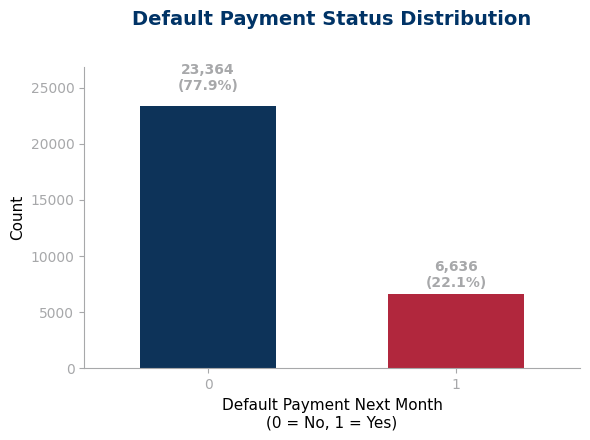

In [9]:
# Defining the colors.
red = '#C8102E'
blue = '#003366'
gray = '#A7A8AA'

# count the target values and calculate percentages
counts = df['default_payment_next_month'].value_counts().sort_index()
percentages = counts / counts.sum() * 100

plt.figure(figsize=(6, 4.5))


ax = sns.barplot(
    x=counts.index,
    y=counts.values,
    hue=counts.index,
    palette=[blue, red],
    dodge=False,
    width=0.55,
    legend=False
)

# title and axis labels
plt.title(
    'Default Payment Status Distribution',
    fontsize=14,
    fontweight='bold',
    color=blue,
    pad=30
)
plt.xlabel('Default Payment Next Month\n(0 = No, 1 = Yes)', fontsize=11)
plt.ylabel('Count', fontsize=11)

# add count + percentage labels above the bars
for i, (count, pct) in enumerate(zip(counts.values, percentages.values)):
    ax.text(
        i,
        count * 1.05,
        f'{count:,}\n({pct:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color=gray
    )

# styling
sns.despine()
ax.spines['bottom'].set_color(gray)
ax.spines['left'].set_color(gray)
ax.tick_params(colors=gray)

# adding a little space above the highest bar
plt.ylim(0, counts.max() * 1.15)

plt.tight_layout()
plt.savefig('y_distribution.jpg', dpi=400)
plt.show()


**Interpretation of the Default Payment Status Distribution Figure:** The Default Payment Status Distribution highlights the difference between the two target classes. The majority class (class 0 — no default next month) contains 23,364 instances, whereas the minority class (class 1 — default next month) includes 6,636 instances. This translates to approximately 78% non-default and 22% default cases. Such an imbalance suggests that predictive models trained on this dataset may inherently favor the majority class unless corrective measures are applied. During modeling, I am thinking of considering techniques like SMOTE oversampling to mitigate this effect and ensure robust model performance.

## Moving forward let's look at data distributionsa and identify if we have any outliers.

## ---Explore Credit Limit Related Feature---

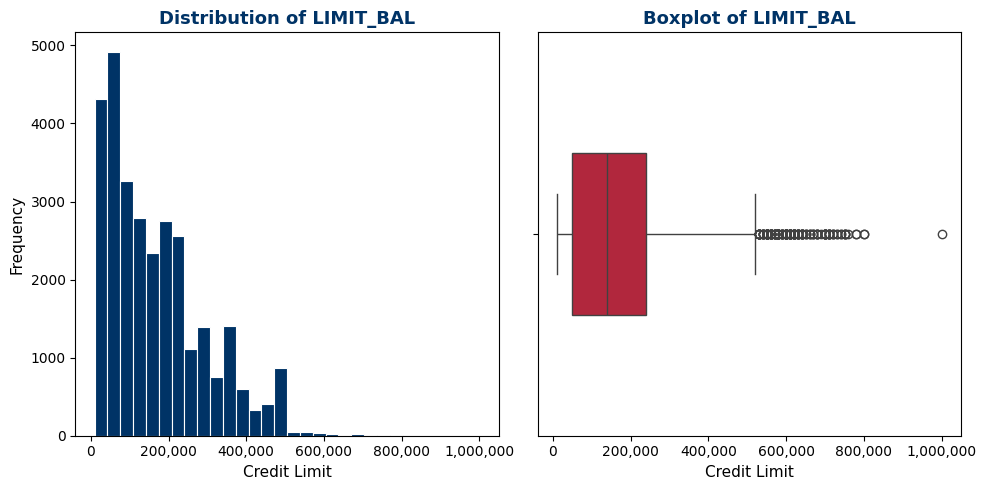

In [10]:
plt.figure(figsize=(10, 5))

# To save space, I organized the figures into subplots (1 row, 2 columns).
# --- Histogram / Distribution ---
plt.subplot(1, 2, 1)
sns.histplot(df['LIMIT_BAL'], kde=False, color=blue, bins=30, edgecolor='white', alpha=1.0, linewidth=0.8)
plt.title('Distribution of LIMIT_BAL', fontsize=13, fontweight='bold', color=blue)
plt.xlabel('Credit Limit', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
#plt.grid(axis='y', linestyle='--', color=delta_gray, alpha=0.6)

# --- Boxplot ---
plt.subplot(1, 2, 2)
sns.boxplot(x=df['LIMIT_BAL'], color=red, width=0.4)
plt.title('Boxplot of LIMIT_BAL', fontsize=13, fontweight='bold', color=blue)
plt.xlabel('Credit Limit', fontsize=11)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig('limit_bal_distribution.jpg', dpi = 400)
plt.show()


**Interprepation:** The LIMIT_BAL distribution is left-skewed, with the majority of observations falling between 0 and roughly 600,000. The boxplot’s upper whisker reaches a bit above 600,000, and the remaining points beyond that range are flagged as outliers.

## ---Explore Demographic Factors---

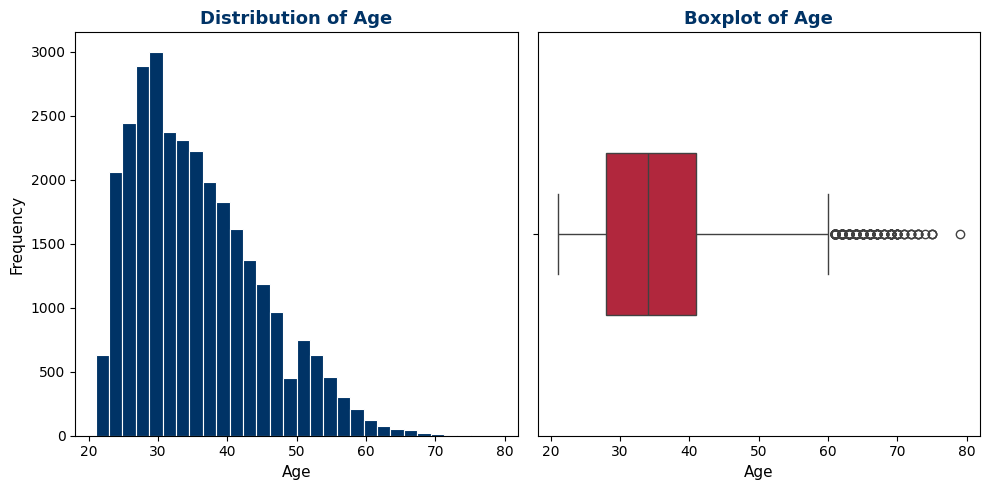

In [11]:
plt.figure(figsize=(10, 5))

# --- Histogram / Distribution ---
plt.subplot(1, 2, 1)
sns.histplot(df['AGE'], kde=False, color=blue, bins=30, edgecolor='white', alpha=1.0, linewidth=0.8)
plt.title('Distribution of Age', fontsize=13, fontweight='bold', color=blue)
plt.xlabel('Age', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# --- Boxplot ---
plt.subplot(1, 2, 2)
sns.boxplot(x=df['AGE'], color=red, width=0.4)
plt.title('Boxplot of Age', fontsize=13, fontweight='bold', color=blue)
plt.xlabel('Age', fontsize=11)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()


**Interpretation:** The age distribution shows that the most customers fall between ages 25 and 45, with a noticeable peak around the early 30s. As age increases beyond 45, the frequency steadily declines, and very few customers are above 60.

The boxplot shows a median age in the mid-30s, with the interquartile range roughly between the late 20s and early 40s. The whiskers extend out to about age 60, and observations above that point appear as outliers, indicating a small number of much older customers in the dataset.

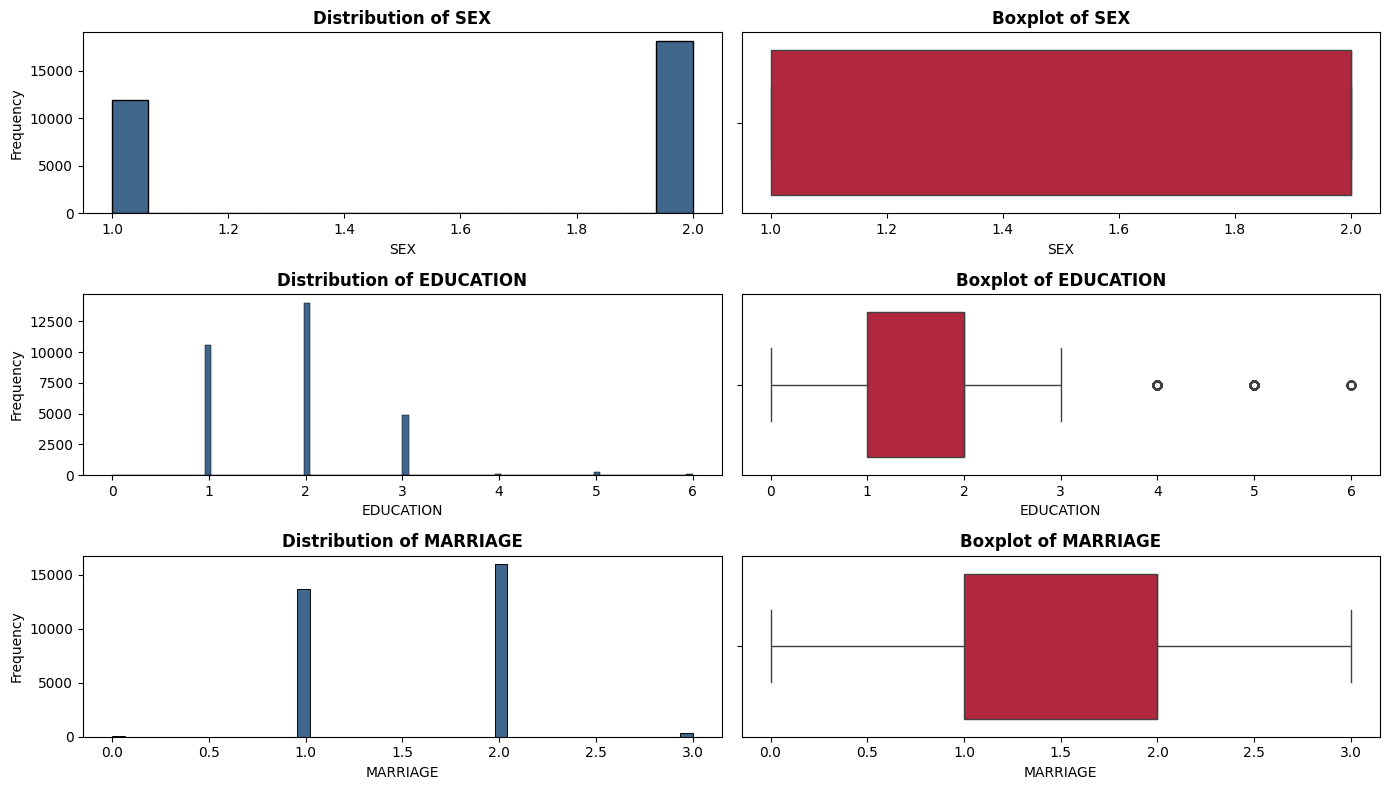

In [12]:
# Selected the 3 demographic variables to explore
variables = ['SEX', 'EDUCATION', 'MARRIAGE']

# Figure layout
plt.figure(figsize=(14, 8))

for i, var in enumerate(variables):
    # Histogram (distribution)
    plt.subplot(3, 2, 2*i + 1)
    sns.histplot(df[var], kde=False, color='#003366')
    plt.title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(3, 2, 2*i + 2)
    sns.boxplot(x=df[var], color='#C8102E')
    plt.title(f'Boxplot of {var}', fontsize=12, fontweight='bold')
    plt.xlabel(var)

plt.tight_layout()
plt.show()


**Interpretation:** The *SEX variable* shows a simple binary distribution with two clear groups and no outliers. *EDUCATION* has most customers falling into levels 1, 2, and 3, while higher categories (4–6) appear rarely and show up as outliers in the boxplot. For *MARRIAGE*, most customers are in categories 1 and 2, with category 3 appearing less frequently and a few unusual values near 0 showing up as outliers. For a few categories, such as Education 0 or 6, I have not noticed the decoding or description for what they represent. I need to do some additional search to figure out what these categories represent.

In [13]:
# Here I want to take a quick look at the counts for each category.

print(df['SEX'].value_counts())
print(df['EDUCATION'].value_counts())
print(df['MARRIAGE'].value_counts())
#print(df['AGE'].value_counts())

SEX
2    18112
1    11888
Name: count, dtype: int64
EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64
MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64


## ---Explore Payment Related Features---

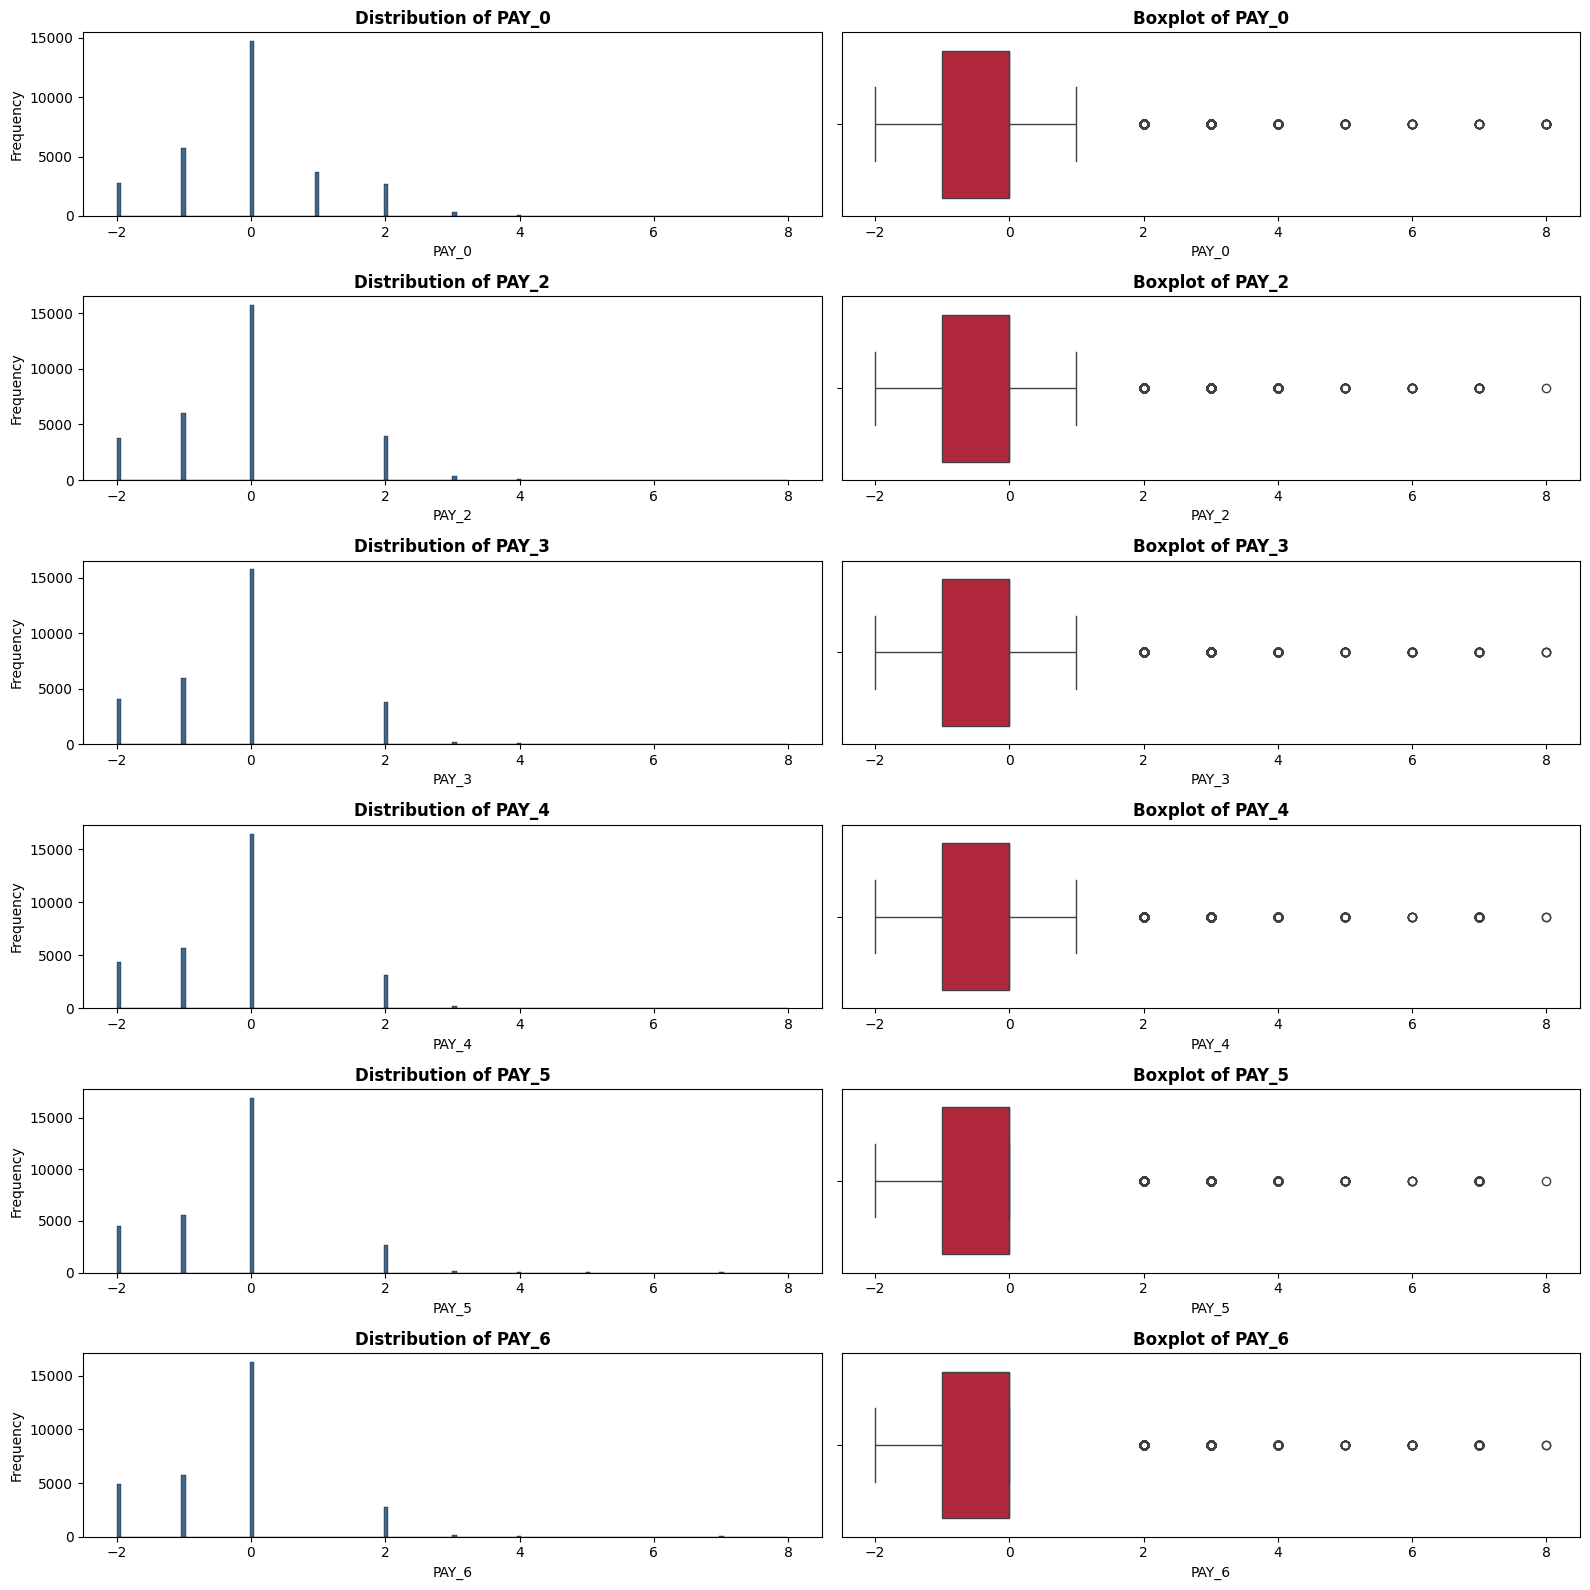

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pay-related variables to explore
variables = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Set up figure layout
plt.figure(figsize=(16, 16))

for i, var in enumerate(variables):
    # Histogram (distribution)
    plt.subplot(6, 2, 2*i + 1)
    sns.histplot(df[var], kde=False, color='#003366')
    plt.title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    plt.xlabel(var)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(6, 2, 2*i + 2)
    sns.boxplot(x=df[var], color='#C8102E')
    plt.title(f'Boxplot of {var}', fontsize=12, fontweight='bold')
    plt.xlabel(var)

plt.tight_layout()
plt.show()


**Interpretation:** The PAY variables (PAY_0 through PAY_6) all follow a very similar pattern. Most customers fall in the “0” category, which indicates they paid on time for that month. Smaller groups appear in “-1” and “-2,” and only a small fraction of customers move into the higher delay categories (2, 3, 4, etc.). The boxplots reinforce this: the distribution is tightly centered around 0, and anything above that shows up as a long line of outliers. Notice that, for PAY_5 and PAY_6, the boxplots don’t show whiskers because the variability in the core distribution is extremely small. Almost all observations fall into the same few categories (mostly 0, -1, -2). When the data is this concentrated, the IQR (Q1 to Q3) collapses into a narrow range, and the whiskers don’t extend outward. Everything above that narrow core region is immediately considered an outlier, so seaborn plots them as points instead of whiskers.

In [15]:
# I checked the value counts, and it confirms that PAY_5 and PAY_6 have very few observations
# outside the main categories (0, -1, and -2).

#print(df['PAY_0'].value_counts())
#print(df['PAY_2'].value_counts())
#print(df['PAY_3'].value_counts())
#print(df['PAY_4'].value_counts())
print(df['PAY_5'].value_counts())
print(df['PAY_6'].value_counts())

PAY_5
 0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: count, dtype: int64
PAY_6
 0    16286
-1     5740
-2     4895
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: count, dtype: int64


## ---Explore Bill Amount Related Features---

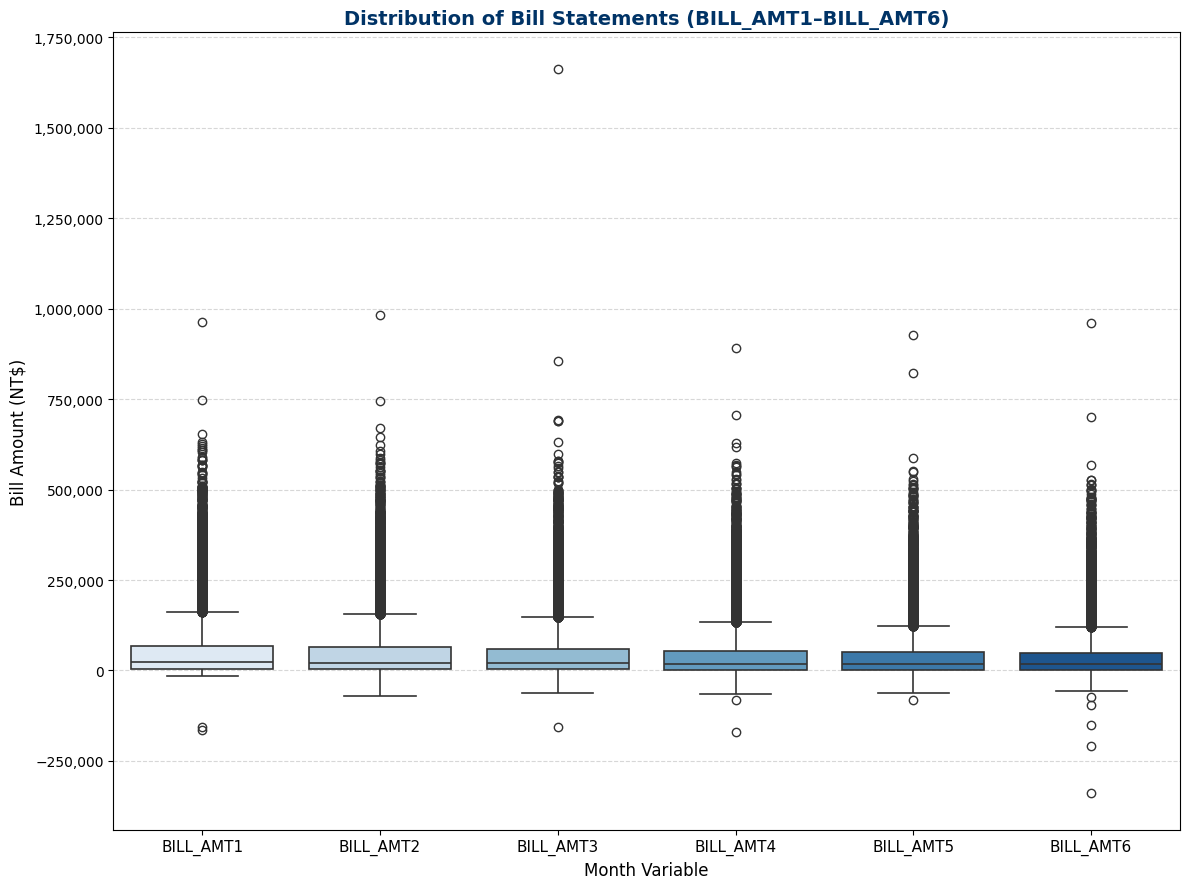

In [16]:
# This visualization is pretty dense and cluttered, so it’s not the cleanest way to look at the data.
# That’s why in the next code block I separated each boxplot into its own panel for better clarity.

# Column list
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]

plt.figure(figsize=(12, 9))  # wider figure for readability

sns.boxplot(data=df[bill_cols], palette='Blues', linewidth=1.2)

plt.title('Distribution of Bill Statements (BILL_AMT1–BILL_AMT6)', fontsize=14, fontweight='bold', color='#003366')
plt.ylabel('Bill Amount (NT$)', fontsize=12)
plt.xlabel('Month Variable', fontsize=12)
plt.xticks(fontsize=11)

# Format y-axis numbers in plain format with commas
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


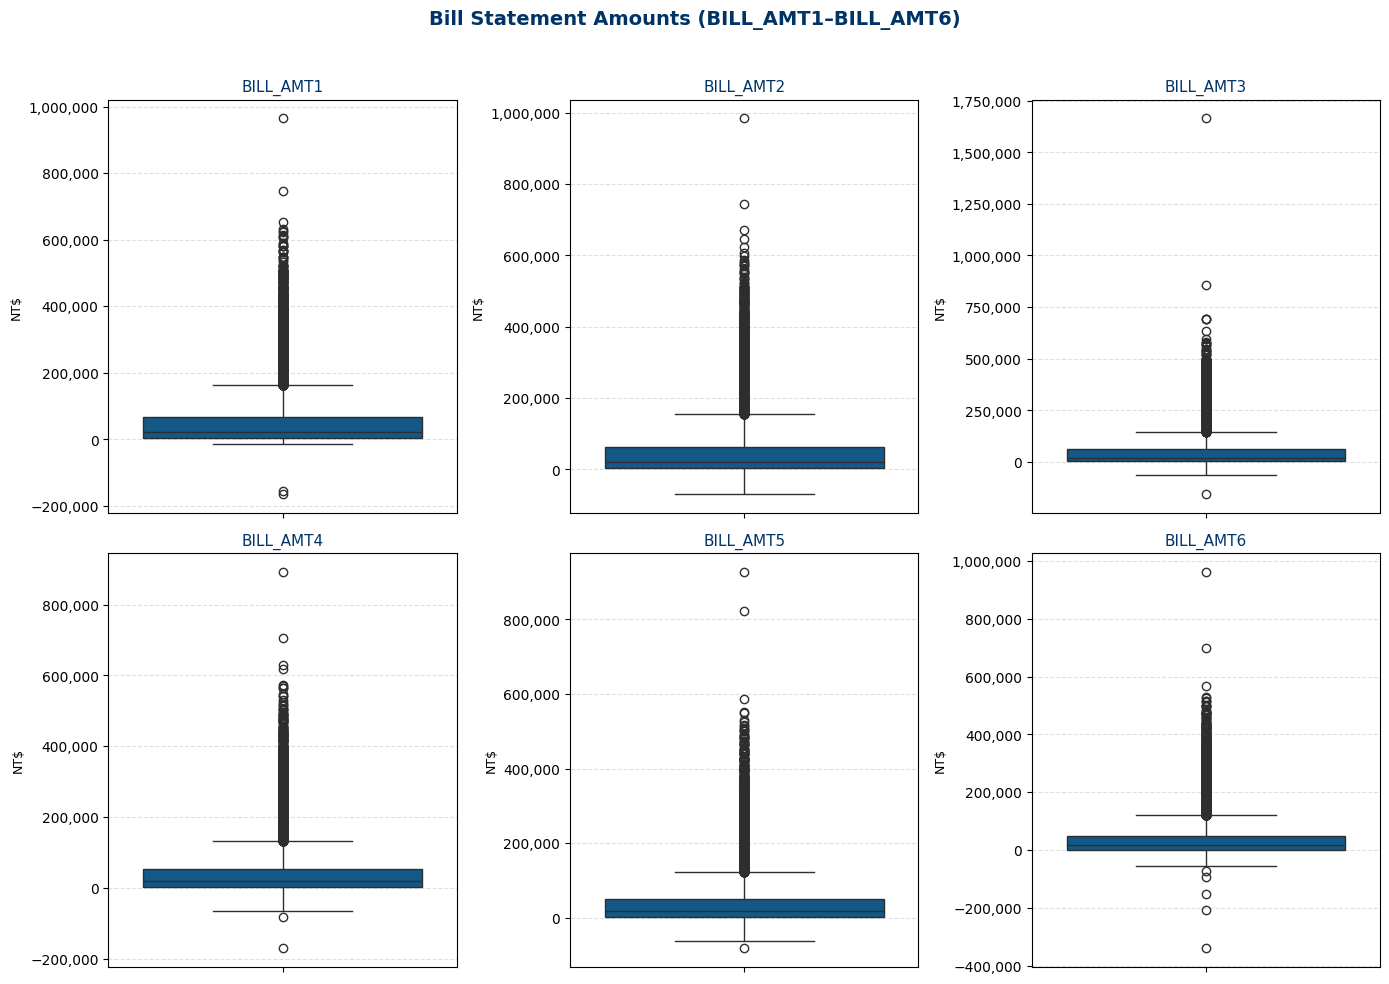

In [17]:
# Visualizng the Bill Amounts

bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]

fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(bill_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='#005C99', linewidth=1)
    axes[i].set_title(col, fontsize=11, color='#003366')
    axes[i].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('NT$', fontsize=9)
    axes[i].grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle('Bill Statement Amounts (BILL_AMT1–BILL_AMT6)', fontsize=14, fontweight='bold', color='#003366')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Interpretation:** This figure shows the distribution of bill statement amounts across six months (BILL_AMT1 to BILL_AMT6). Across all six variables, the pattern is very similar: most values cluster near the lower end, while a long tail stretches upward with many high-value outliers. The medians are relatively low, but the range is extremely wide, indicating large variation in customers’ outstanding balances.

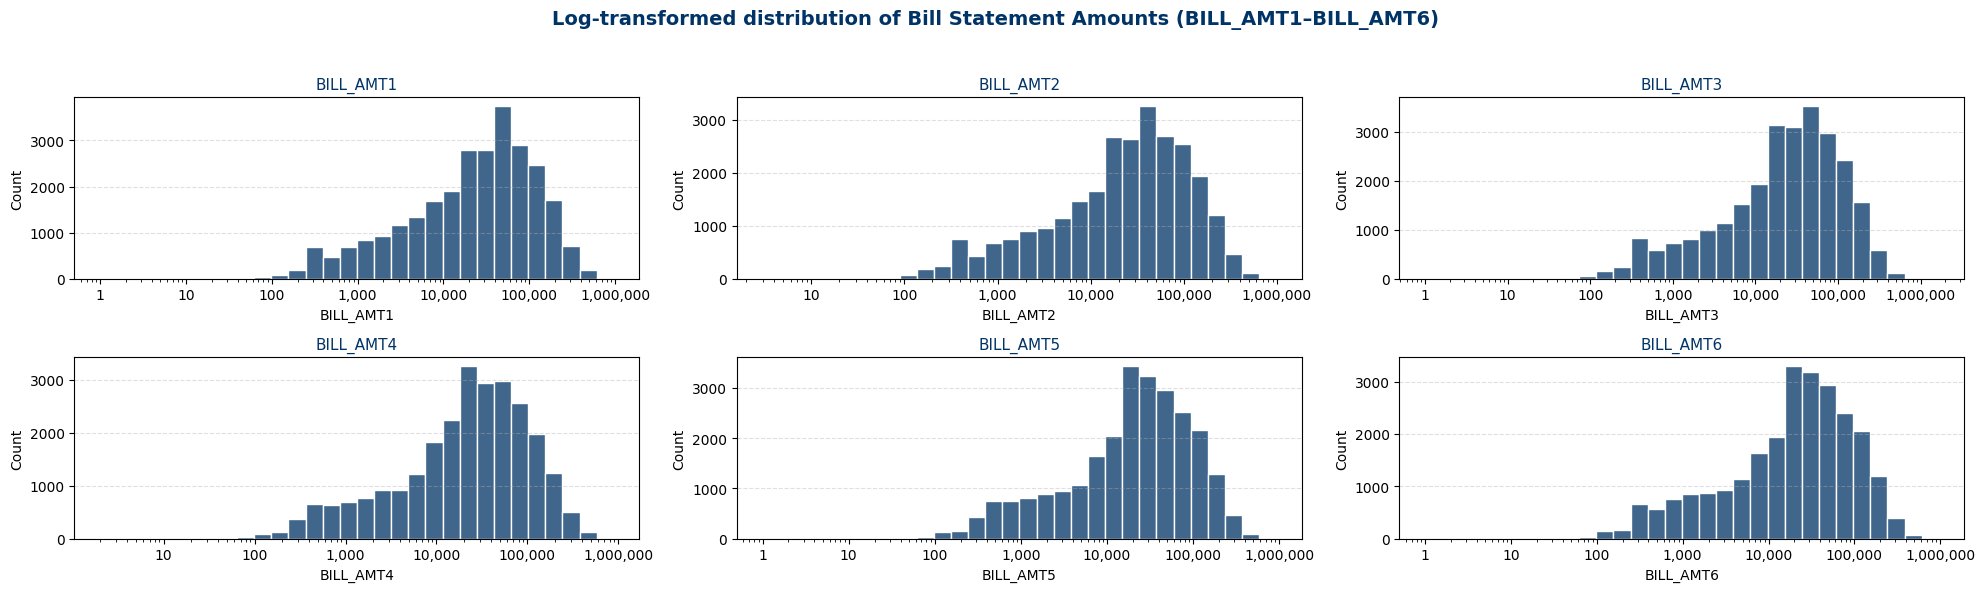

In [18]:
# We can also apply a log scale.
# Using a log scale helps when the data is heavily skewed, like the bill amounts here.
# It compresses very large values and spreads out the smaller ones, making the overall distribution
# easier to see. Instead of one giant cluster near zero and a long tail of huge outliers,
# the log scale balances the shape so both common and extreme values are visible.


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
fig, axes = plt.subplots(2, 3, figsize=(20, 6))
axes = axes.flatten()

for i, col in enumerate(bill_cols):
  # to see the original data destribution without log-transformation,
  # we can set log_scale=False
    sns.histplot(df[col], bins=30, log_scale=True, color='#003366', edgecolor='white', ax=axes[i])
    axes[i].set_title(col, fontsize=11, color='#003366')
    axes[i].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    axes[i].grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle('Log-transformed distribution of Bill Statement Amounts (BILL_AMT1–BILL_AMT6)', fontsize=14, fontweight='bold', color='#003366')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Interpretation:** After applying the log scale, the extremely large values no longer dominate the plot, and the main structure of the data becomes visible. Across all six months, the distributions show a similar pattern: most customers have bill amounts in the lower to mid ranges, with a smooth decline as the amounts increase. The log scale spreads out the smaller values and compresses the very large ones, so the overall shape and trends are clearer compared to the original histograms.

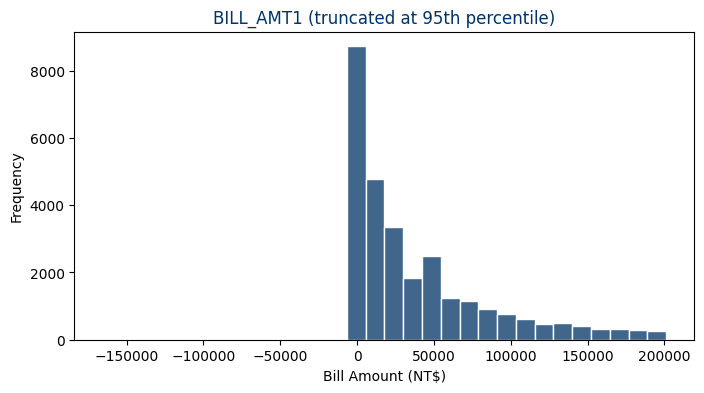

In [19]:
# Except for the log transformation we can also trancate the data.
# Truncated visualization of the features

col = 'BILL_AMT1'

# Compute cutoff for the top 5%
cutoff = df[col].quantile(0.95) # we can adjust to 0.90, 0.95, etc.

plt.figure(figsize=(8, 4))
sns.histplot(df[df[col] <= cutoff][col], bins=30, color='#003366', edgecolor='white')
plt.title(f'{col} (truncated at 95th percentile)', fontsize=12, color='#003366')
plt.xlabel('Bill Amount (NT$)')
plt.ylabel('Frequency')
plt.show()

**Interpretation:** This code creates a truncated version of the BILL_AMT1 histogram by removing the top 5 percent of values. Since the bill amounts have a very long right tail with extremely large outliers, the full histogram gets dominated by those values and hides the structure of the rest of the data. By cutting off everything above the 95th percentile, we can zoom in on the main portion of the distribution and see the shape more clearly.

In [20]:
# Saving these figures so I can easily include them later in the report if needed.

for col in bill_cols:
    sns.histplot(df[col], bins=30, color='#003366', edgecolor='white')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Bill Amount (NT$)')
    plt.ylabel('Frequency')
    plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    plt.savefig(f'{col}_hist.png', dpi=400)
    plt.close()


## ---Explore Payment Related Features---

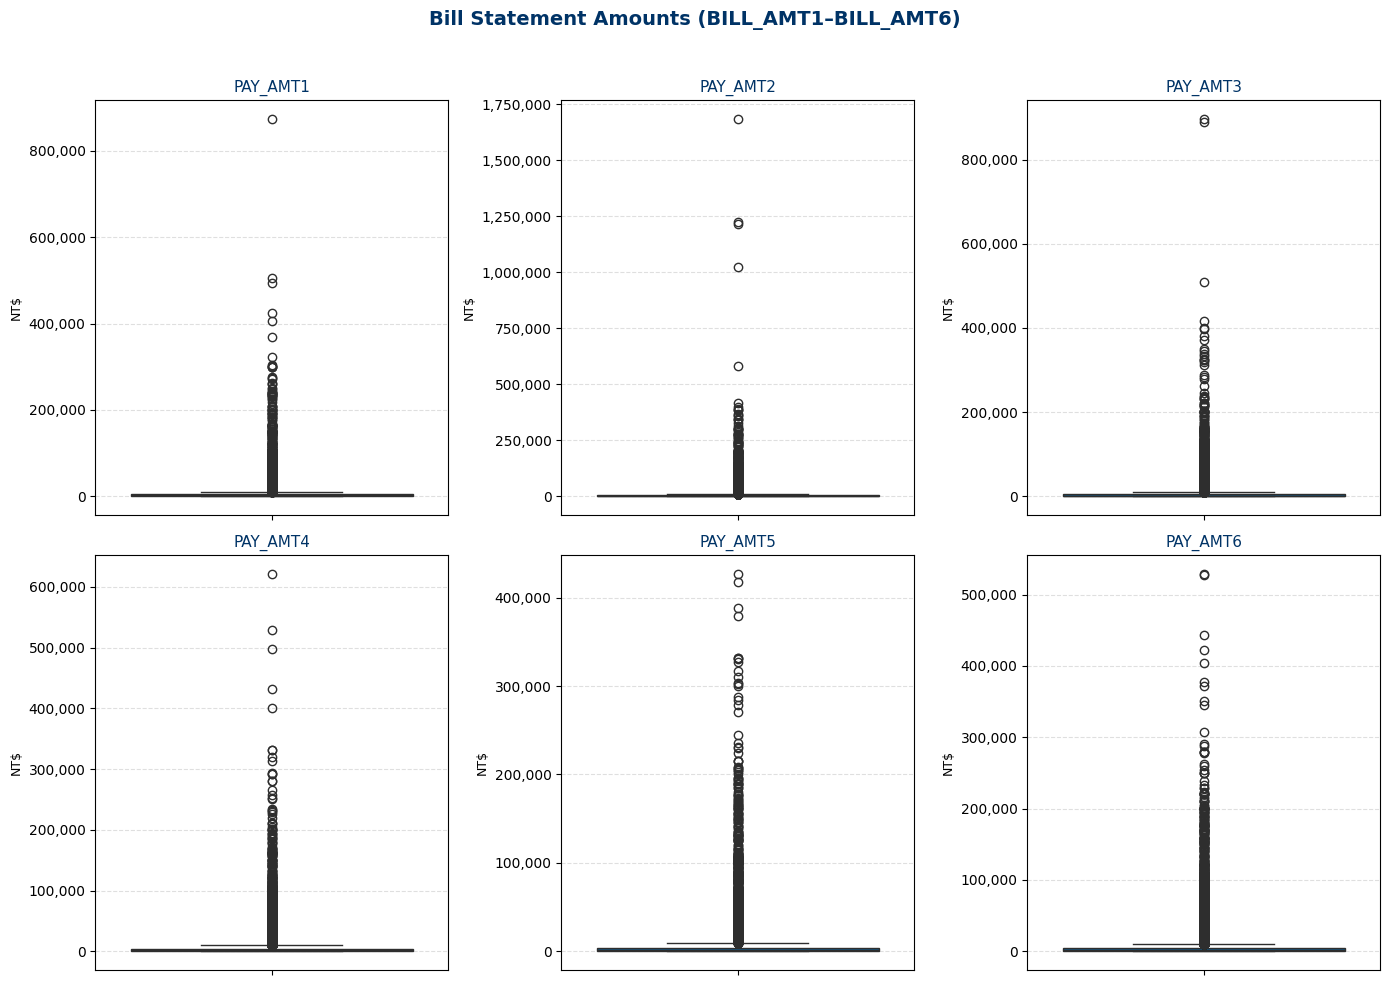

In [21]:
bill_cols = [f'PAY_AMT{i}' for i in range(1, 7)]

fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(bill_cols):
    sns.boxplot(y=df[col], ax=axes[i], color='#005C99', linewidth=1)
    axes[i].set_title(col, fontsize=11, color='#003366')
    axes[i].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    axes[i].set_xlabel('')
    axes[i].set_ylabel('NT$', fontsize=9)
    axes[i].grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle('Bill Statement Amounts (BILL_AMT1–BILL_AMT6)', fontsize=14, fontweight='bold', color='#003366')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Interpretation:** In all six plots, most repayment amounts are clustered very close to zero. A small group of customers made very large payments, which appear as the vertical line of outliers rising far above the main distribution. The we can observe that the majority of customers make relatively small monthly payments, and only a small subset makes very high repayments, creating a long right tail.

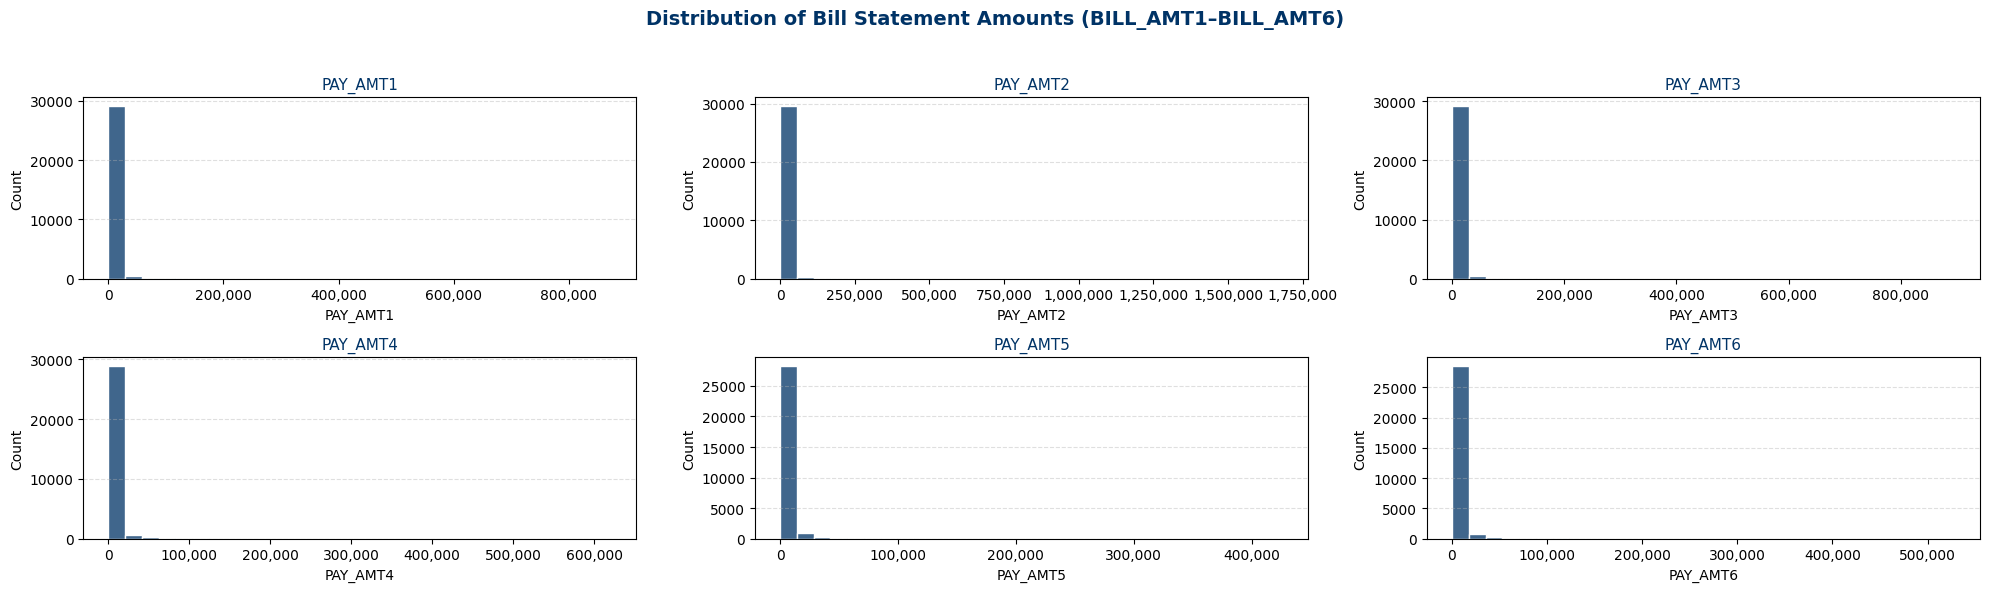

In [22]:
# Visualizing the previous payment features
# The initial plots show many extreme outliers, making the distributions hard to interpret.
# To improve clarity, the figures can be truncated to highlight where most data points are concentrated.

bill_cols = [f'PAY_AMT{i}' for i in range(1, 7)]
fig, axes = plt.subplots(2, 3, figsize=(20, 6))
axes = axes.flatten()

for i, col in enumerate(bill_cols):
    sns.histplot(df[col], bins=30, color='#003366', edgecolor='white', ax=axes[i])
    axes[i].set_title(col, fontsize=11, color='#003366')
    axes[i].xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    axes[i].grid(axis='y', linestyle='--', alpha=0.4)

plt.suptitle('Distribution of Bill Statement Amounts (BILL_AMT1–BILL_AMT6)', fontsize=14, fontweight='bold', color='#003366')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Interpretation:** This code creates a truncated version of the BILL_AMT1 histogram by removing the top 5 percent of values. Since the bill amounts have a very long right tail with extremely large outliers, the full histogram gets dominated by those values and hides the structure of the rest of the data. By cutting off everything above the 95th percentile, we can zoom in on the main portion of the distribution and see the shape more clearly.

In [23]:
# From the figure above, I noticed that we have some negative values,
# even though they don’t show up clearly in the histogram bars.
# To understand this better, I checked how many cases fall below zero,
# and there are 590 of them, with the lowest value around -165,580.
# This indicates that for some customers, the bill statement reflected a credit balance
# (meaning they had overpaid or had excess credit on the account).

 # 590 costumer overpaid, or the bank adjusted/refunded an amount.
col = 'BILL_AMT1'
(df[col] < 0).sum(), df[col].min()


(np.int64(590), -165580)

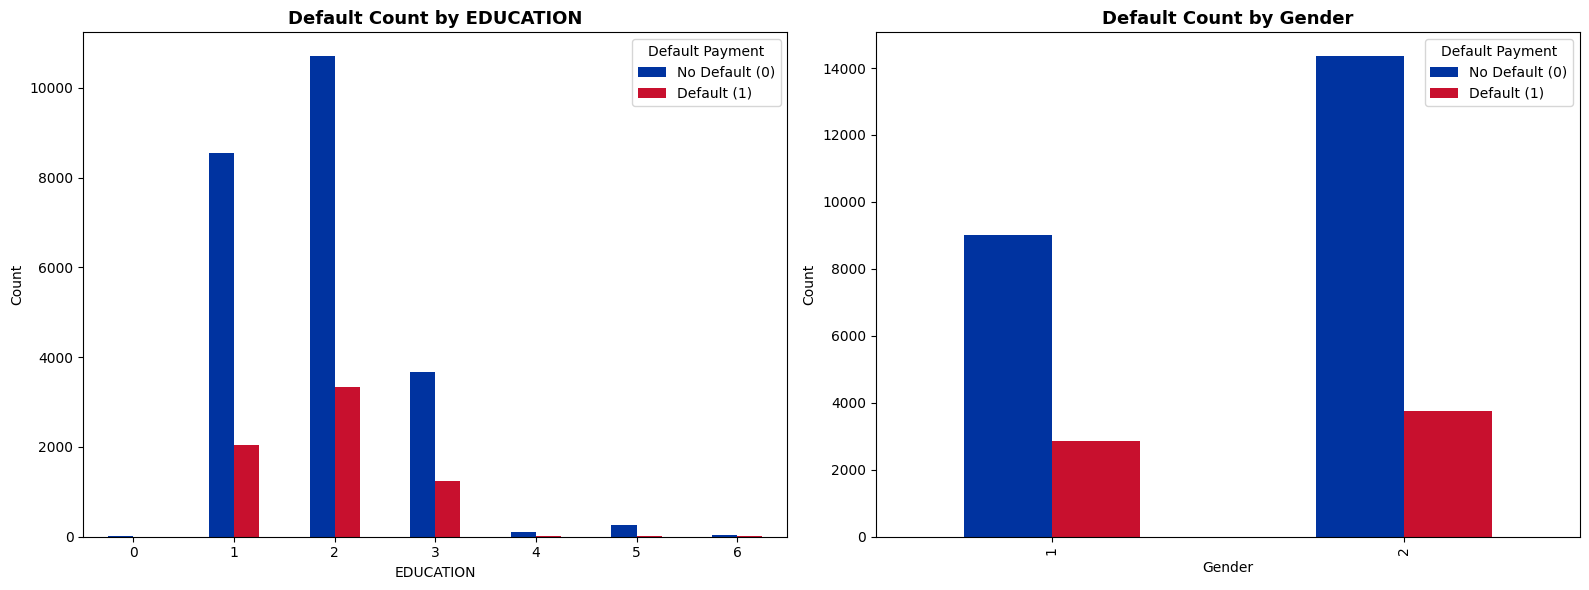

In [24]:
# Pivot tables for counts
edu_df = df.pivot_table(
    index='EDUCATION',
    columns='default_payment_next_month',
    aggfunc='size',
    fill_value=0
)

age_df = df.pivot_table(
    index='SEX',
    columns='default_payment_next_month',
    aggfunc='size',
    fill_value=0
)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Subplot 1: EDUCATION ---
edu_df.plot(
    kind='bar',
    ax=axes[0],
    color=['#0033A0', '#C8102E'],
)
axes[0].set_title("Default Count by EDUCATION", fontsize=13, fontweight='bold')
axes[0].set_xlabel("EDUCATION")
axes[0].set_ylabel("Count")
axes[0].legend(title='Default Payment', labels=['No Default (0)', 'Default (1)'])
axes[0].tick_params(axis='x', rotation=0)

# --- Subplot 2: Gender ---
age_df.plot(
    kind='bar',
    ax=axes[1],
    color=['#0033A0', '#C8102E'],
)
axes[1].set_title("Default Count by Gender", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Count")
axes[1].legend(title='Default Payment', labels=['No Default (0)', 'Default (1)'])
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


**Interpretation:** The Figure on the left shows how default counts vary across different education levels. Most customers fall into education levels 1, 2, and 3, and we can see that level 2 has the highest number of defaults simply because it has the largest group overall. The trend is consistent across the categories: the number of defaults increases as the total number of customers in that education level increases. There are note any obvious spikes where one education group defaults at a noticeably higher rate than others.

The Figure on the right presents defaults counts by gender. Similar to the education plot, the counts mostly reflect the size of each group. Gender “2” has more customers in the dataset, so it also shows more defaults. There isn’t a strong difference suggesting that one gender defaults more frequently than the other.

In [25]:
# I created this pivot table to calculate the default percentage within each gender.
# Counts alone only reflect group size, so converting to percentages helps compare
# default behavior fairly between categories.
# we can do this for the other demographic variables  as well

# Pivot table of counts
sex_df = df.pivot_table(
    index='SEX',
    columns='default_payment_next_month',
    aggfunc='size',
    fill_value=0
)

# Convert to percentages row-wise
sex_pct = sex_df.div(sex_df.sum(axis=1), axis=0) * 100

print(sex_pct)


default_payment_next_month          0          1
SEX                                             
1                           75.832773  24.167227
2                           79.223719  20.776281


**Interpretation:** SEX = 1 (male) has a slightly higher default rate compared to SEX = 2 (female), but the difference is not large.

In [26]:
# Creating a contingency table of counts between SEX and default status.
# This shows how many customers in each gender group defaulted or not.
contingency = pd.crosstab(df['SEX'], df['default_payment_next_month'])

# Running a Chi-square test to check whether SEX and default behavior
# are statistically dependent or if the differences we see are just by chance.
chi2, p_value, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p_value)


# Calculating Cramer's V to measure the strength of the association.
# Chi-square tells us whether an association exists; Cramer's V tells us how strong it is.
n = contingency.sum().sum()
chi2 = chi2
k = min(contingency.shape) - 1  # for 2x2 table, k = 1

cramers_v = np.sqrt(chi2 / (n * k))
print("Cramer's V:", cramers_v)


Chi-square: 47.70879689062111
p-value: 4.944678999412044e-12
Cramer's V: 0.03987848078459572


**Interpretation:** Even though the p-value shows a statistically significant association between SEX and default status, Cramer's V is only 0.04, which indicates a very weak effect. This means gender is not a strong or meaningful predictor of default behavior.


**Notice:** This type of categorical analysis can be extended to other demographic or behavioral variables. For example, we can analyze default rates by marital status to determine whether single, married, (or another category) individuals exhibit differences. Likewise, AGE can be binned into ranges (such as young adults, middle-aged adults, and older adults) to examine whether certain age cohorts are more likely to default. These comparisons can reveal patterns that may not be apparent when looking at raw numerical variables alone.

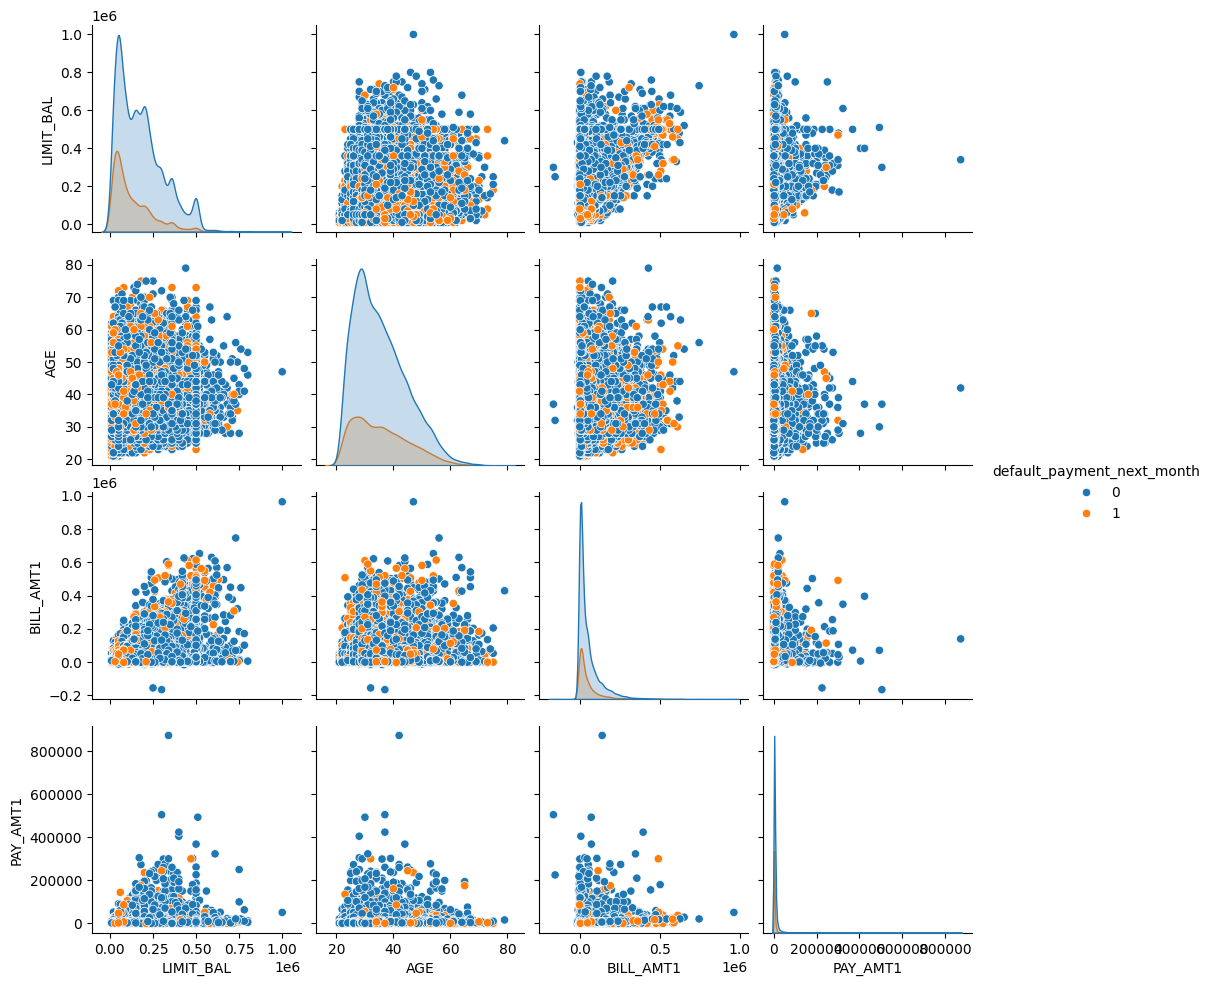

In [27]:
# looking at bivariate associations and distributions
sns.pairplot(df[['LIMIT_BAL','AGE','BILL_AMT1','PAY_AMT1','default_payment_next_month']],
             hue='default_payment_next_month', diag_kind='kde')


**Interpretation:** This pairplot gives a quick visual overview of how a few key variables relate to each other, with points colored by default status. Across all scatterplots, the blue and orange points overlap heavily, which suggests that LIMIT_BAL, AGE, BILL_AMT1, and PAY_AMT1 don’t clearly separate the default and non-default groups on their own. The diagonal KDE plots also show very similar distributions for both classes. Overall, this confirms that there isn’t a strong, simple boundary between the two groups based on these raw features, and more complex modeling will be needed to capture default patterns.

# --- Correlation Analysis ---

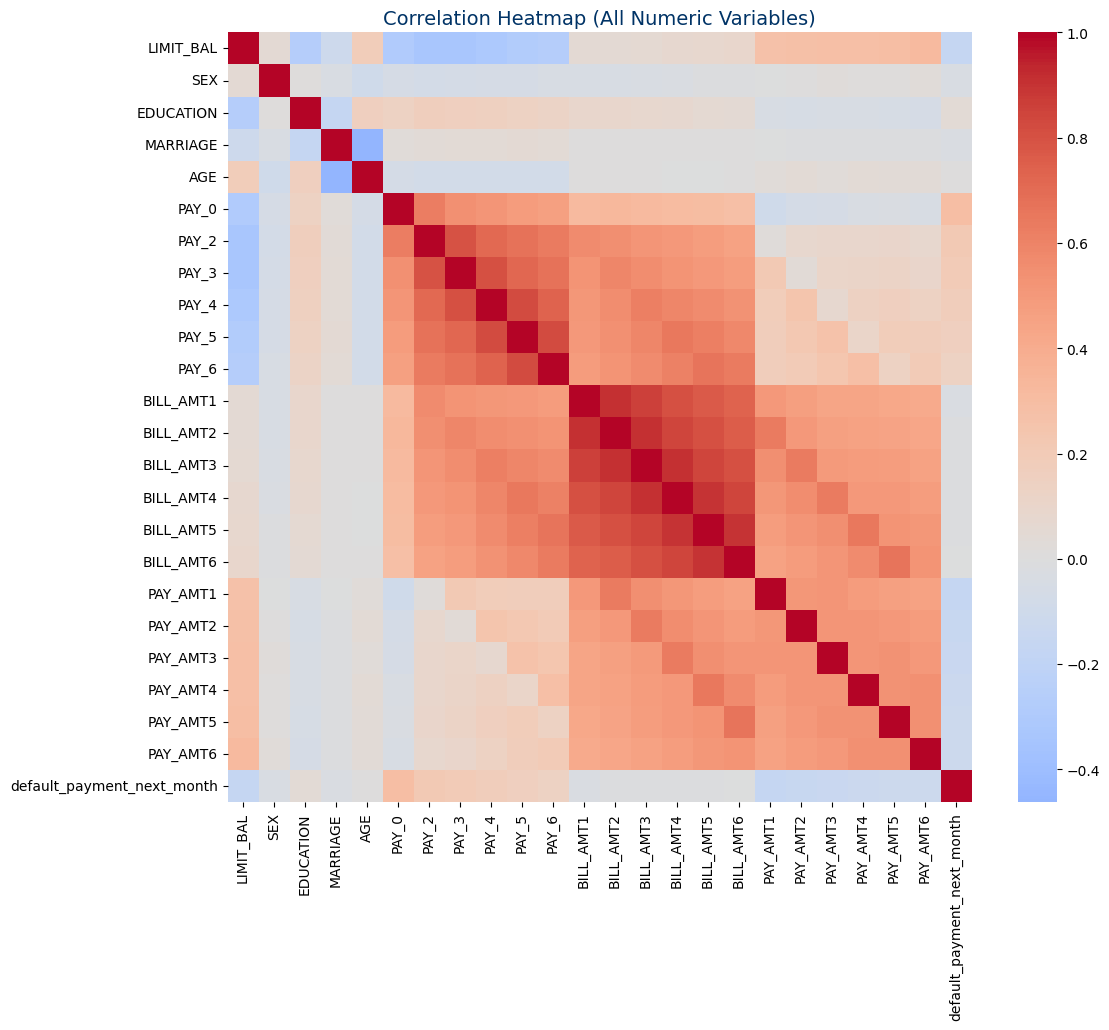

In [28]:
# Evaluating the associations between the variables
corr = df.corr(method='spearman')

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (All Numeric Variables)', fontsize=14, color='#003366')
plt.show()


**Interpretation:** The heatmap shows two strong correlation blocks: the PAY variables are highly correlated with each other, and the BILL_AMT variables are also strongly correlated across months. Most demographic variables (SEX, EDUCATION, MARRIAGE, AGE) show very weak correlations with everything, including default. The default variable itself has only moderate correlation with the PAY features, and very weak correlation with the rest.

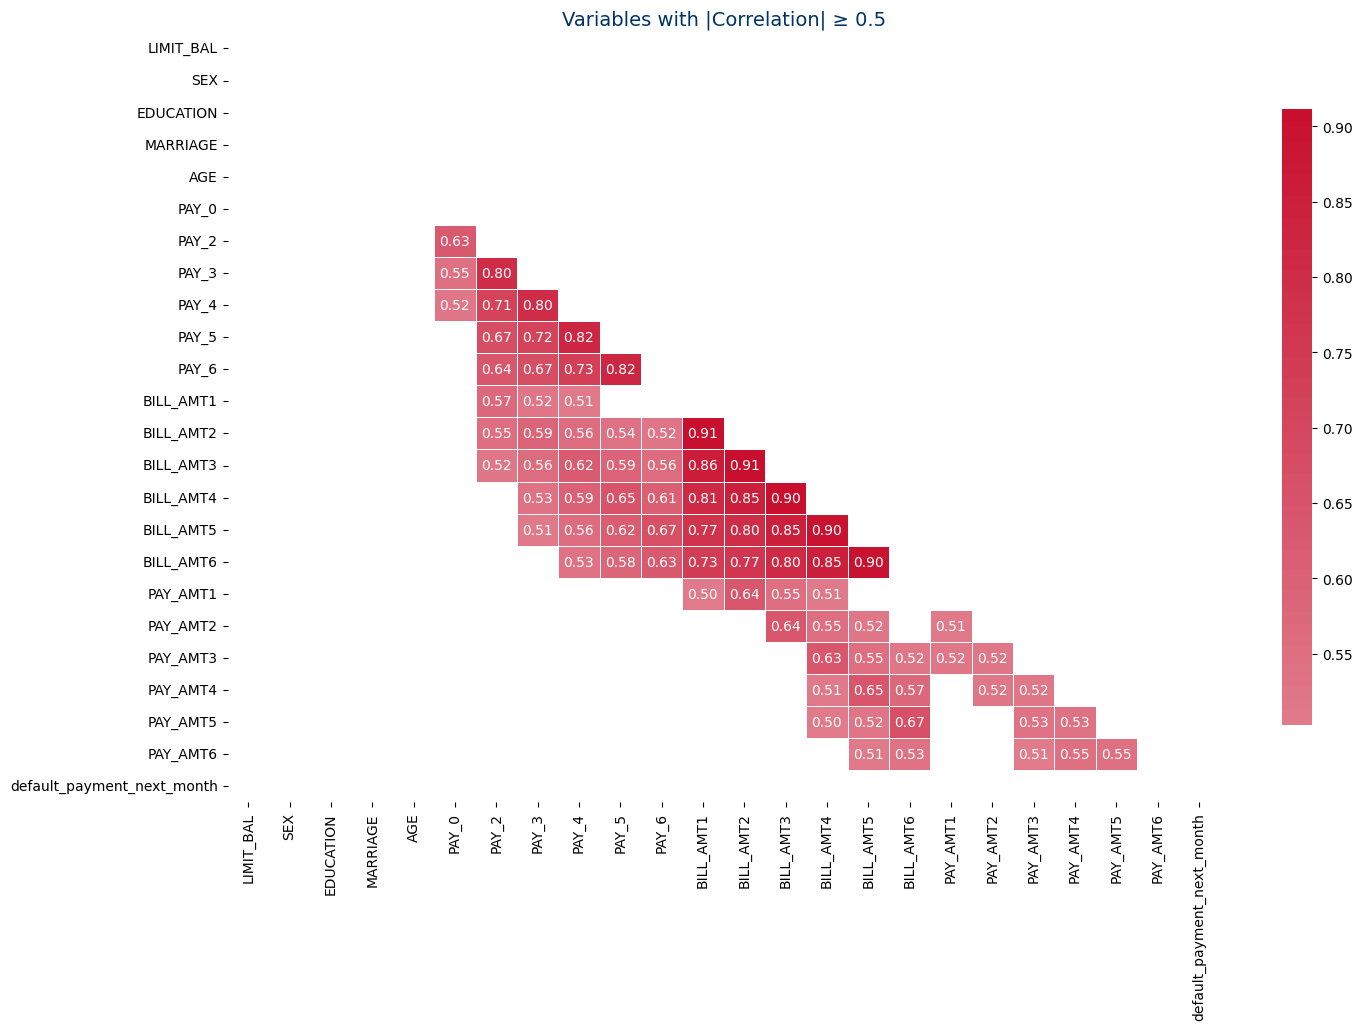

In [29]:
# Here I’m focusing only on the variables that have stronger correlations (>= 0.5).

# I’m also using Spearman correlation since many of these variables are not normally distributed.
# Spearman captures monotonic relationships better for this dataset.

# The upper triangle is masked just to make the heatmap cleaner and easier to read.
# This way I can quickly see which pairs of variables stand out.


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

blue = "#003366"
red = "#C8102E"

cmap = LinearSegmentedColormap.from_list("delta", [blue, "white", red], N=256)

# Calculate the correlation matrix
corr = df.corr(method='spearman')

# Define a threshold for high correlation
threshold = 0.5

# Filter the correlation matrix to show only high correlations (absolute value >= threshold)
# and exclude self-correlations (diagonal)
high_corr = corr[(abs(corr) >= threshold) & (abs(corr) < 1.0)]

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(high_corr, dtype=bool))

plt.figure(figsize=(16, 10))
sns.heatmap(
    high_corr,
    mask=mask,                # hide upper triangle
    annot=True,
    cmap=cmap,
    center=0,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title(f'Variables with |Correlation| ≥ {threshold}', fontsize=14, color=blue)
plt.show()

**Interpretation:** This figure again highlights that payment related features are highly correlated. See for example, BILL_AMT5 and BILL_AMT6, correlation value = 0.9.

Overall, correlation output shows customers tend to have steady patterns of spending and repayment over time. The amounts billed each month are highly consistent, i.e., customers tend to carry over similar balances month after month. As well as customers’ repayment habits are consistent. Those who pay late in one month are likely to pay late again. This temporal persistence reflects behavioral consistency in financial activities.

Some of the high correlations (0.8 and above) suggests multicollinearity issue, among the monthly billing and payment variables, and may suggest features carry redundant information.

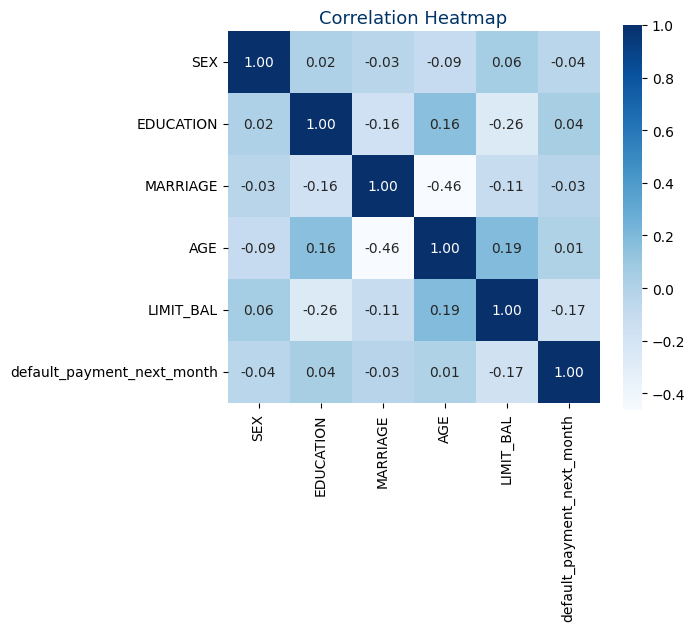

In [30]:
# I have looked the correlation between the demographic factors and the target
# which shows almost no correlation

cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'LIMIT_BAL', 'default_payment_next_month']
corr = df[cols].corr(method='spearman')   # 'pearson'
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', square=True)
plt.title('Correlation Heatmap', fontsize=13, color='#003366')
plt.show()

In [31]:
# Mutual Information Crieteria

from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y, random_state=199)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

print(mi_df)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Feature  MI_Score
5       PAY_0  0.077101
6       PAY_2  0.047511
7       PAY_3  0.038847
9       PAY_5  0.030330
8       PAY_4  0.028943
10      PAY_6  0.025447
17   PAY_AMT1  0.022930
19   PAY_AMT3  0.019743
21   PAY_AMT5  0.015827
0   LIMIT_BAL  0.014610
20   PAY_AMT4  0.014435
18   PAY_AMT2  0.013923
22   PAY_AMT6  0.011812
11  BILL_AMT1  0.011091
16  BILL_AMT6  0.009020
15  BILL_AMT5  0.006938
1         SEX  0.006827
12  BILL_AMT2  0.005740
13  BILL_AMT3  0.004864
14  BILL_AMT4  0.004761
2   EDUCATION  0.004273
3    MARRIAGE  0.002447
4         AGE  0.000000


**Interpretation:** The MI results show that the PAY_x variables share the most information with the target., with PAY_0 clearly leading. The payment amount variables add some additional but smaller information. LIMIT_BAL has a moderate contribution, while the billing amounts and demographic features contribute very little. AGE shows essentially no mutual information.

# **Deliverable 2: Model Development**
## **Machine Learning and Feature Selection Analysis**

## ✅ The EDA results highlighted several factors that we should keep in mind as we move into the modeling phase.


1. **Class imbalance** in the target variable: the number of non-default cases far exceeds default cases. Techniques such as SMOTE, class-weight adjustments, or other imbalance-handling methods may be necessary.

2. **Scale imbalance across features**: some variables (e.g., BILL_AMT features) have values in the hundreds of thousands, while others range from 1–5. Many ML models will interpret larger scales as more influential unless features are standardized or normalized.

3. **Highly skewed distributions and outliers**: several variables, such as BILL_AMT1 and payment-related features, show heavy skewness. Applying log-transformations or other normalization techniques can help stabilize variance and improve model performance.

4. **Multicollinearity among predictors**: strong correlations exist between several bill and payment amount features. Methods such as Variance Inflation Factor (VIF) or dimensionality reduction can help mitigate this issue.

5. **Sparse categories in categorical variables**: some categorical groups (e.g., EDUCATION categories 4, 5, and 6) have very small sample sizes. Combining or re-grouping these categories can result in more reliable patterns and model estimates.

***Given these observations, I first established a baseline using Logistic Regression with both the original and PCA-reduced feature sets (from the EDA analysis). Next, building on this baseline, I focus on tree-based models such as Random Forest, XGBoost, and LightGBM, which naturally handle multicollinearity and nonlinear relationships. For each model, I report performance metrics and feature-importance results to identify the most influential predictors.***

## **Evaluation of the Models**

For model evaluation, I decided to focus on three main metrics: *Accuracy, F1 Score, and ROC-AUC.* *Accuracy* gives a general idea of how often the model is correct, but on an imbalanced dataset it can be misleading because the majority class dominates the score. The *F1 Score* is more informative here because it balances precision and recall, and tells me how well the model is detecting the minority class, which is the harder part of the problem. *ROC-AUC* measures how well the model separates the two classes across different thresholds. A higher AUC means the model is better at ranking default vs. non-default customers, which is useful when the dataset is imbalanced.


In [33]:
# Please make sure the data is loaded and that the features and target are defined.
# This is the same setup we used earlier when starting the EDA section.
# Here we also split the data into train and test sets, that will be used for the modeling

from ucimlrepo import fetch_ucirepo
# Fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)
# Features and target
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets

# Let’s replace those X1, X2 placeholders with the real column names from the
# dataset description so it’s clearer what each variable represents.
column_names = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

X.columns = column_names

# Create a new DataFrame df and combine features and target
df = X.copy()
df['default_payment_next_month'] = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=199, stratify=y
)

# View the DataFrame
df.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   default_payment_next_month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0

In [34]:
######################### Random Forest Classifier ###########################
# Random Forest: builds many independent decision trees on bootstrapped samples
# and averages their predictions. It reduces overfitting and handles noisy or
# imbalanced data well.
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=199,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))
print("*********************")

######################### XGBoost ###########################
# XGBoost is a gradient boosting method that builds trees sequentially,
# where each new tree focuses on correcting the errors of the previous ones.

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=199
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_prob))
print("*********************")

######################### LightGBM ###########################
# LightGBM is also a boosting algorithm but grows trees leaf-wise instead of
# level-wise, making it much faster and more efficient on large datasets.
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=199
)


lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_test)
lgb_prob = lgb_model.predict_proba(X_test)[:, 1]

print("LightGBM Results:")
print("Accuracy:", accuracy_score(y_test, lgb_pred))
print("F1 Score:", f1_score(y_test, lgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, lgb_prob))



/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Results:
Accuracy: 0.8135
F1 Score: 0.4538799414348463
ROC-AUC: 0.7649481033195719
*********************
XGBoost Results:
Accuracy: 0.819
F1 Score: 0.4743465634075508
ROC-AUC: 0.7791500855255488
*********************
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
LightGBM Results:
Accuracy: 0.8183333333333334
F1 Score: 0.4713870029097963
ROC-AUC: 0.7802343337142891


**Interpretation:** All three models have similar performances. Random Forest does well overall but has the lowest F1 and ROC-AUC among the three. XGBoost and LightGBM both perform slightly better, with XGBoost edging out the others on accuracy and ROC-AUC, and LightGBM close behind. The F1 scores are all relatively low, which makes sense because the dataset is imbalanced and defaults are harder to predict. Overall, boosted models (XGBoost and LightGBM) capture the patterns a bit better than Random Forest.

In [35]:
######################### Categorial Boosting ###########################

# Categorial Boosting algorithm is gradient boosting algorithm
# that is designed to handle categorical features natively without needing one-hot encoding.
# It uses ordered boosting and built-in encoders to reduce overfitting and handle imbalance well.

# Identify categorical columns
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object' or X[col].nunique() < 20]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=199, stratify=y
)

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=199,
    verbose=False,
    class_weights=[1, 3]   # handle imbalance
)

catboost_model.fit(X_train, y_train, cat_features=cat_features)

# Predictions
catboost_pred = catboost_model.predict(X_test)
catboost_prob = catboost_model.predict_proba(X_test)[:, 1]

print("CatBoost Results:")
print("Accuracy:", accuracy_score(y_test, catboost_pred))
print("F1 Score:", f1_score(y_test, catboost_pred))
print("ROC-AUC:", roc_auc_score(y_test, catboost_prob))


CatBoost Results:
Accuracy: 0.7846666666666666
F1 Score: 0.5476190476190477
ROC-AUC: 0.7846367183991281


**Interpretation:** CatBoost has the highest F1 score among all the models, which means it’s doing a better job identifying the default cases compared to Random Forest, XGBoost, and LightGBM. Its ROC-AUC is also very competitive and slightly higher than Random Forest, and almost tied with XGBoost and LightGBM. The accuracy is lower, but that’s expected because accuracy is dominated by the majority class, and CatBoost is clearly prioritizing the minority class better.

In [36]:
# CatBoost measures feature importance by looking at how much each feature reduces the loss
# across all trees in the boosting process. For categorical variables, it incorporates the
# internal encodings CatBoost uses, so the importance reflects how useful each feature was
# in improving the model’s predictions.


catboost_model.get_feature_importance(prettified=True).head(20)

Feature Id  Importances
0       PAY_0    12.497012
1   BILL_AMT1     8.584273
2   LIMIT_BAL     8.449509
3    PAY_AMT3     5.786144
4    PAY_AMT6     4.919135
5    PAY_AMT2     4.852454
6   BILL_AMT4     4.509821
7    PAY_AMT1     4.461160
8         AGE     4.313943
9   BILL_AMT3     4.229203
10   PAY_AMT4     4.107559
11   PAY_AMT5     3.879063
12  BILL_AMT2     3.820812
13  BILL_AMT6     3.754392
14  BILL_AMT5     3.726104
15  EDUCATION     3.445771
16      PAY_4     2.986769
17      PAY_2     2.484394
18      PAY_6     2.068803
19      PAY_3     1.947144

Interpretation: The feature importance results show that PAY_0 is the strongest predictor in the CatBoost model. LIMIT_BAL and BILL_AMT1 also rank high, followed by the PAY_AMT variables, showing that repayment amounts across months also help the model distinguish between customers who default and those who do not. Demographic variables like AGE, EDUCATION, and MARRIAGE appear lower on the list, which indicates that they contribute some information but are not as influential as the financial behavior features.

In [37]:
# this just gives clean summary of model performances

results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'Accuracy': [
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test, lgb_pred),
        accuracy_score(y_test, catboost_pred)
    ],
    'F1 Score': [
        f1_score(y_test, rf_pred),
        f1_score(y_test, xgb_pred),
        f1_score(y_test, lgb_pred),
        f1_score(y_test, catboost_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, rf_prob),
        roc_auc_score(y_test, xgb_prob),
        roc_auc_score(y_test, lgb_prob),
        roc_auc_score(y_test, catboost_prob)
    ]
})

results


Model  Accuracy  F1 Score   ROC-AUC
0  Random Forest  0.813500  0.453880  0.764948
1        XGBoost  0.819000  0.474347  0.779150
2       LightGBM  0.818333  0.471387  0.780234
3       CatBoost  0.784667  0.547619  0.784637

## Tree-based Model Importances

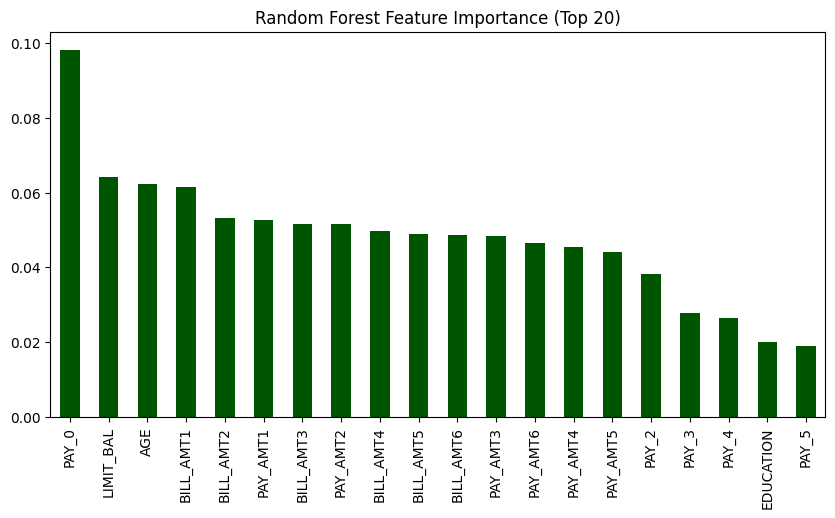

In [38]:
# below you can see the random forst feature importances

rf_importances = pd.Series(rf.feature_importances_, index=X.columns)
rf_importances.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10,5), color='#005500')
plt.title("Random Forest Feature Importance (Top 20)")
plt.show()


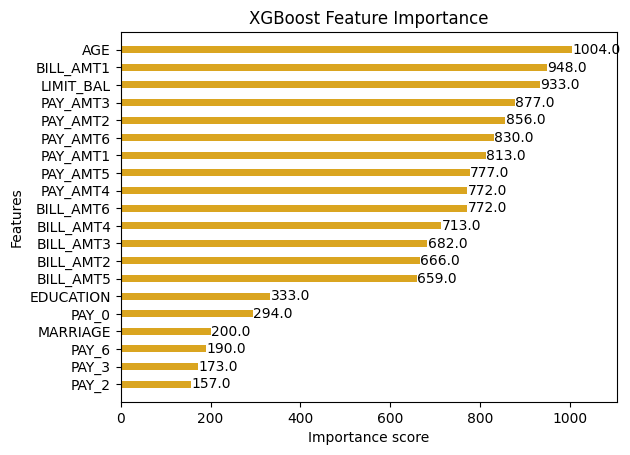

In [39]:
ax = xgb.plot_importance(xgb_model, max_num_features=20, height=0.4, color='#DAA520')
plt.title("XGBoost Feature Importance")
ax.grid(False)
plt.show()


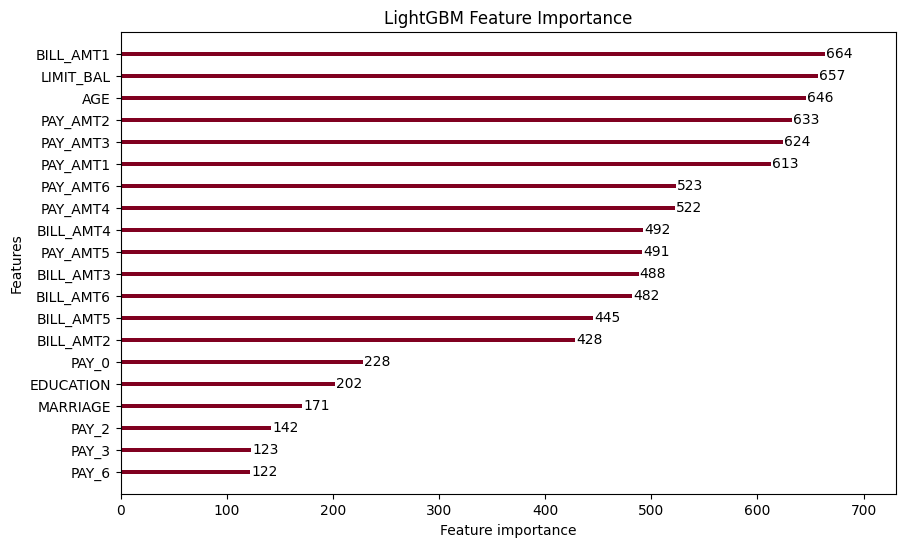

In [40]:
lgb = lgb.plot_importance(lgb_model, max_num_features=20, figsize=(10,6), color='#800020')
lgb.grid(False)
plt.title("LightGBM Feature Importance")
plt.show()


**Interpretation:** From Random Forest, XGBoost, and LightGBM analysis we can see that the most important features for the prediction are the recent bill amounts, payment amounts, credit limit, age, and the recent repayment status (PAY_0). Random Forest shows PAY_0 and credit limit as top features, while XGBoost and LightGBM place heavier weight on the bill-amount and payment-amount variables across different months. Although each model ranks them slightly differently, they all agree that the customer’s recent financial behavior (how much they owe, how much they pay, and their credit capacity) is far more important for predicting default than demographic features like education or marriage status.

## Recursive Feature Elimination (Based on Random Forest)

In [41]:
# # Recursive Feature Elimination (RFE) is a feature selection method that works by
# repeatedly removing the least important features to reduce the dataset and keep
# only the predictors that contribute the most.

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=199)

rfe = RFE(estimator=rf, n_features_to_select=10)  # keep top 10
rfe.fit(X, y)

# Which features were selected
selected_features = X.columns[rfe.support_]
ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()

print("Top 10 Selected Features:")
print(selected_features)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Top 10 Selected Features:
Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1'],
      dtype='object')


**Interpretation:** The RFE approach suggests ten features. LIMIT_BAL, AGE, and PAY_0 show up consistently as strong predictors, and all six BILL_AMT variables are included, which reflects how closely monthly bill amounts relate to default behavior. PAY_AMT1 also appears, meaning the most recent repayment amount carries useful information about the target. Overall, RFE is confirming the same features as the tree-based models: recent bill amounts, credit limit, and repayment status are the most important drivers of default in this dataset.

## Additional Machine Learning Models

Below, I evaluate several machine learning models to see how well they predict customer default behavior. I include both models that require feature scaling (logistic regression, Naive Bayes, SVM, and neural networks) and tree-based models that do not require scaling (Random Forest, XGBoost, LightGBM, CatBoost). This helps me compare linear, probabilistic, kernel-based, neural, and boosting-based approaches on the same problem.


In [42]:
# ------------------------------
# DATA SPLIT
# ------------------------------
X = df.drop(columns=['default_payment_next_month'])
y = df['default_payment_next_month']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=199, stratify=y
)


# ------------------------------
# SCALER
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ------------------------------
# MODELS THAT REQUIRE SCALING
# ------------------------------
scaled_models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000, class_weight="balanced"),

    "NaiveBayes": GaussianNB(),

    "SVM": SVC(probability=True, kernel="rbf", C=1.0, random_state=199),

    "MLPClassifier": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        max_iter=500,
        random_state=199)
}


# ------------------------------
# MODELS THAT DO *NOT* REQUIRE SCALING
# ------------------------------
non_scaled_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=199),

    "XGBoost": xgb.XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", random_state=199),

    "LightGBM": LGBMClassifier(
        n_estimators=300, learning_rate=0.05, random_state=199),

    "CatBoost": CatBoostClassifier(
        iterations=300, learning_rate=0.05, verbose=0, random_state=199)
}


# ------------------------------
# FEEDFORWARD NEURAL NET (scaled input)
# ------------------------------
def build_ffnn(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

ffnn = build_ffnn(X_train_scaled.shape[1])


# ------------------------------
# EVALUATION FUNCTION
# ------------------------------
def evaluate_model(name, model, Xtr, ytr, Xte, yte, is_keras=False):
    if not is_keras:
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        prob = model.predict_proba(Xte)[:, 1]
    else:
        model.fit(Xtr, ytr, epochs=15, batch_size=64, verbose=0)
        prob = model.predict(Xte).flatten()
        pred = (prob >= 0.5).astype(int)

    return {
        "Model": name,
        "Accuracy": accuracy_score(yte, pred),
        "F1": f1_score(yte, pred),
        "ROC_AUC": roc_auc_score(yte, prob)
    }


# ------------------------------
# RUN ALL MODELS
# ------------------------------
results = []

# models requiring scaling
for name, model in scaled_models.items():
    print(f"Training (scaled) {name}...")
    results.append(
        evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test)
    )

# models NOT requiring scaling
for name, model in non_scaled_models.items():
    print(f"Training (non-scaled) {name}...")
    results.append(
        evaluate_model(name, model, X_train, y_train, X_test, y_test)
    )

# Feedforward NN
results.append(
    evaluate_model("Feedforward_NN", ffnn,
                   X_train_scaled, y_train, X_test_scaled, y_test,
                   is_keras=True)
)


# ------------------------------
# RESULTS TABLE
# ------------------------------
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="ROC_AUC", ascending=False))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training (scaled) LogisticRegression...
Training (scaled) NaiveBayes...
Training (scaled) SVM...
Training (scaled) MLPClassifier...
Training (non-scaled) RandomForest...
Training (non-scaled) XGBoost...
Training (non-scaled) LightGBM...
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3263
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training from score -1.258639
Training (non-scaled) CatBoost...
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                Model  Accuracy        F1   ROC_AUC
7            CatBoost  0.821000  0.481660  0.786205
6            LightGBM  0.81

**Interpretation:** The boosting models (CatBoost, LightGBM, XGBoost) consistently provide the strongest overall performance, and Logistic Regression has the lowest accuracy. Most of the models struggle predicting the minority class, due to the class imbalance issue.

## LASSO

Since logistic regression performed the weakest among the models, I wanted to apply LASSO (L1-regularized logistic regression) to see whether shrinking and removing weak features could improve its performance and give a cleaner, more interpretable set of predictors.

In [43]:
# LASSO

# Create a pipeline: scale data + L1-regularized logistic regression
lasso_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(
        penalty='l1',
        solver='liblinear',  # required for L1
        C=0.1,               # inverse of regularization strength (smaller = stronger)
        random_state=199
    ))
])

lasso_clf.fit(X, y)

# Extract feature coefficients
coef = lasso_clf.named_steps['lasso'].coef_[0]
lasso_features = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coef,
    'Selected': coef != 0
}).sort_values(by='Coefficient', ascending=False)

print(lasso_features)

      Feature  Coefficient  Selected
5       PAY_0     0.649142      True
6       PAY_2     0.097258      True
7       PAY_3     0.089186      True
13  BILL_AMT3     0.079474      True
4         AGE     0.066517      True
12  BILL_AMT2     0.039361      True
9       PAY_5     0.038574      True
15  BILL_AMT5     0.030070      True
8       PAY_4     0.027814      True
16  BILL_AMT6     0.022741      True
10      PAY_6     0.009400      True
14  BILL_AMT4     0.000000     False
22   PAY_AMT6    -0.035341      True
19   PAY_AMT3    -0.048191      True
21   PAY_AMT5    -0.048691      True
1         SEX    -0.050839      True
20   PAY_AMT4    -0.059852      True
2   EDUCATION    -0.076465      True
3    MARRIAGE    -0.078244      True
0   LIMIT_BAL    -0.098376      True
17   PAY_AMT1    -0.192427      True
18   PAY_AMT2    -0.208158      True
11  BILL_AMT1    -0.270866      True


In [44]:
# --------------------------------------
# Build Logistic Regression using ONLY
# LASSO-selected features
# --------------------------------------

# 1. Identify selected features
selected = lasso_features[lasso_features['Selected'] == True]['Feature'].tolist()
print("\nSelected LASSO Features:", selected)

# 2. New feature matrix with only selected columns
X_sel = X[selected]

# 3. Train-test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_sel, y, test_size=0.2, random_state=199, stratify=y
)

# 4. Scale again because we changed the feature set
scaler_sel = StandardScaler()
X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_sel.transform(X_test_sel)

# 5. Train a regular Logistic Regression model on LASSO-chosen features
logreg_sel = LogisticRegression(
    max_iter=3000,
    class_weight="balanced",
    random_state=199
)

logreg_sel.fit(X_train_sel_scaled, y_train_sel)

# 6. Evaluate the model
pred_sel = logreg_sel.predict(X_test_sel_scaled)
prob_sel = logreg_sel.predict_proba(X_test_sel_scaled)[:, 1]

print("\nPerformance of Logistic Regression using LASSO-selected features:")
print("Accuracy:", accuracy_score(y_test_sel, pred_sel))
print("F1 Score:", f1_score(y_test_sel, pred_sel))
print("ROC-AUC:", roc_auc_score(y_test_sel, prob_sel))



Selected LASSO Features: ['PAY_0', 'PAY_2', 'PAY_3', 'BILL_AMT3', 'AGE', 'BILL_AMT2', 'PAY_5', 'BILL_AMT5', 'PAY_4', 'BILL_AMT6', 'PAY_6', 'PAY_AMT6', 'PAY_AMT3', 'PAY_AMT5', 'SEX', 'PAY_AMT4', 'EDUCATION', 'MARRIAGE', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'BILL_AMT1']

Performance of Logistic Regression using LASSO-selected features:
Accuracy: 0.685
F1 Score: 0.4755826859045505
ROC-AUC: 0.723361012960503


**Interpretation:** LASSO only shrank one coefficient to zero, which means most variables carry at least a little predictive power. Since only one feature was removed, and that feature probably carried minimal information, the model performance stayed the same. LASSO didn’t reveal a big set of redundant or noisy predictors, it just suggested that only one variable had no meaningful linear contribution.

## Neural Network Analysis

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


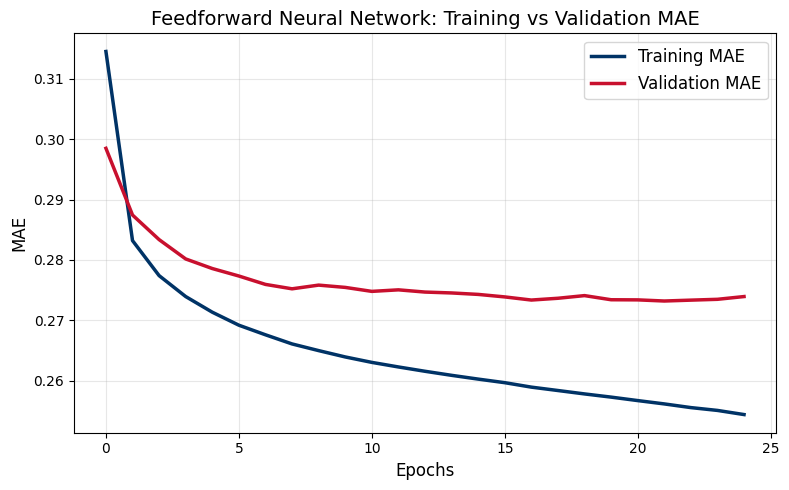

In [45]:
# Rebuild FFNN with MAE included
# Here I was interested to see how MAE is changing over the epochs

# if you comment out this block of code then you will see different MAE output
# this is due to the stochastic nature of NN related to
# random initialization of weights, random shuffling of the training data each epoch
# random 80/20 validation split
##############################################################
seed = 199
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
##############################################################

def build_ffnn_mae(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['mae']  # add MAE
    )
    return model

ffnn_mae = build_ffnn_mae(X_train_scaled.shape[1])

# Train with validation
history = ffnn_mae.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=64,
    verbose=0
)


#############################################
############ Plot the MAE for Training and Validation ############
#############################################
blue = "#003366"
red = "#C8102E"

plt.figure(figsize=(8, 5))
plt.plot(
    history.history['mae'],
    label='Training MAE',
    color=blue,
    linewidth=2.5
)

plt.plot(
    history.history['val_mae'],
    label='Validation MAE',
    color=red,
    linewidth=2.5
)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('Feedforward Neural Network: Training vs Validation MAE', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Saveing the figure
plt.savefig("ffnn_mae_delta_colors.png", dpi=400, bbox_inches="tight")

plt.show()


# SMOTE Operation

SMOTE (Synthetic Minority Oversampling Technique) is a method used to balance an imbalanced dataset by creating new synthetic examples of the minority class instead of just duplicating the existing ones.

In [46]:
# The results, along with the comparison of models with and without SMOTE,
# are presented in the next code block.

# ------------------------------
# APPLY SMOTE ONLY ON TRAINING
# ------------------------------
sm = SMOTE(random_state=199)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Scale original
scaler_orig = StandardScaler()
X_train_scaled = scaler_orig.fit_transform(X_train)
X_test_scaled = scaler_orig.transform(X_test)

# Scale SMOTE version
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)


results_smote = []

# scaled models on SMOTE-balanced, scaled training data
for name, model in scaled_models.items():
    print(f"Training (SMOTE + scaled) {name}...")
    results_smote.append(
        evaluate_model(name, model,
                       X_train_smote_scaled, y_train_smote,
                       X_test_smote_scaled, y_test)
    )

# non-scaled models on SMOTE-balanced, unscaled training data
for name, model in non_scaled_models.items():
    print(f"Training (SMOTE) {name}...")
    results_smote.append(
        evaluate_model(name, model,
                       X_train_smote, y_train_smote,
                       X_test, y_test)
    )

# Feedforward NN
ffnn_smote = build_ffnn(X_train_smote_scaled.shape[1])
results_smote.append(
    evaluate_model("Feedforward_NN_SMOTE", ffnn_smote,
                   X_train_smote_scaled, y_train_smote,
                   X_test_smote_scaled, y_test,
                   is_keras=True)
)


Training (SMOTE + scaled) LogisticRegression...
Training (SMOTE + scaled) NaiveBayes...
Training (SMOTE + scaled) SVM...
Training (SMOTE + scaled) MLPClassifier...
Training (SMOTE) RandomForest...
Training (SMOTE) XGBoost...
Training (SMOTE) LightGBM...
[LightGBM] [Info] Number of positive: 18691, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3448
[LightGBM] [Info] Number of data points in the train set: 37382, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training (SMOTE) CatBoost...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [47]:
results_original = pd.DataFrame(results)
results_balanced = pd.DataFrame(results_smote)

print("ORIGINAL DATA RESULTS:")
print(results_original.sort_values(by="ROC_AUC", ascending=False))

print("\nSMOTE + CLASS WEIGHT RESULTS:")
print(results_balanced.sort_values(by="ROC_AUC", ascending=False))


ORIGINAL DATA RESULTS:
                Model  Accuracy        F1   ROC_AUC
7            CatBoost  0.821000  0.481660  0.786205
6            LightGBM  0.818667  0.477426  0.779631
5             XGBoost  0.818167  0.473710  0.779613
8      Feedforward_NN  0.814000  0.485714  0.773456
4        RandomForest  0.813500  0.453880  0.764948
1          NaiveBayes  0.653833  0.470288  0.729855
2                 SVM  0.819000  0.452621  0.725554
3       MLPClassifier  0.784500  0.455579  0.723232
0  LogisticRegression  0.682167  0.472767  0.723213

SMOTE + CLASS WEIGHT RESULTS:
                  Model  Accuracy        F1   ROC_AUC
7              CatBoost  0.772500  0.503456  0.753992
6              LightGBM  0.775500  0.496072  0.752134
4          RandomForest  0.778167  0.491013  0.751189
5               XGBoost  0.770000  0.482371  0.749421
2                   SVM  0.745833  0.491836  0.738681
8  Feedforward_NN_SMOTE  0.720667  0.491505  0.737912
1            NaiveBayes  0.391000  0.391406  0.7

**Interpretation:** Surprisingly, the application of SMOTE did not increase the F1 score. This outcome suggests that simply expanding the minority class through synthetic oversampling may not have addressed the underlying factors influencing misclassification. Further examination is needed to understand why the F1 score remained stable despite the artificially increased representation of the minority class.

# SHAP, LIME and Permutation Importance

In [48]:
#X = df.drop(columns=['default_payment_next_month'])
#y = df['default_payment_next_month']

#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=199, stratify=y
#)

cat_model = CatBoostClassifier(
    iterations=600,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    verbose=False,
    random_seed=199
)

cat_model.fit(X_train, y_train)

pred = cat_model.predict(X_test)
prob = cat_model.predict_proba(X_test)[:, 1]

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)


/tmp/ipython-input-3237810805.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


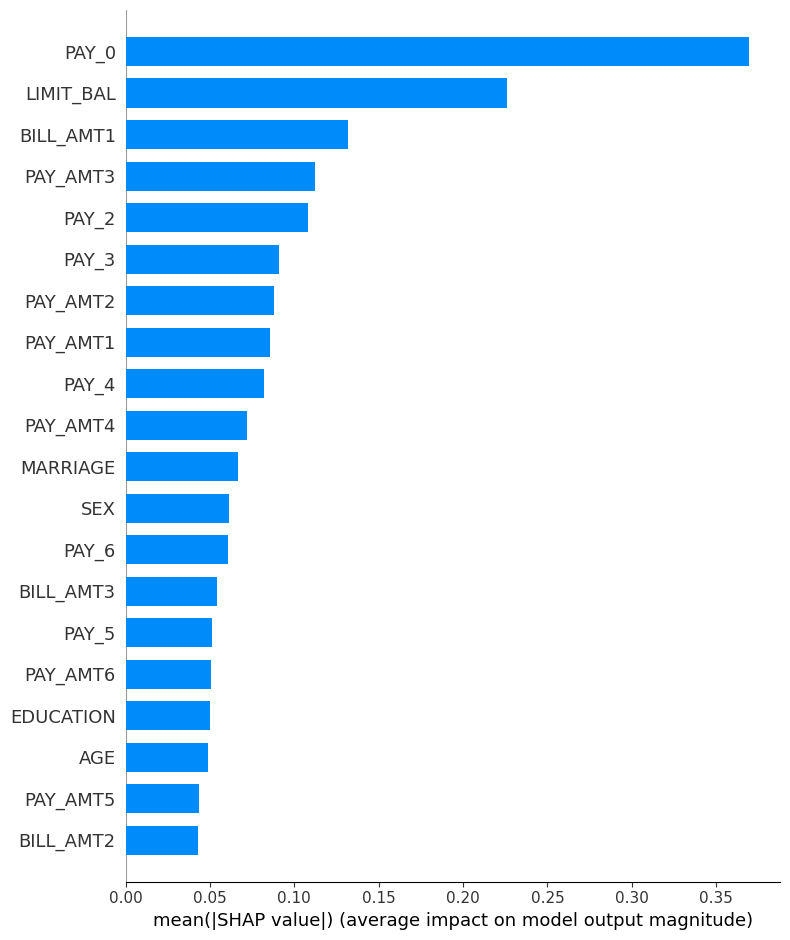

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Interpritation: The SHAP summary plot indicates that PAY_0 (the most recent payment status) is the dominant contributor to the model’s predictions, followed by LIMIT_BAL (credit limit) and BILL_AMT1 (most recent bill amount). These variables exert the largest marginal influence on whether an account is predicted to default. Mid-level contributors include prior payment statuses (PAY_2, PAY_3) and recent payment amounts (PAY_AMT1–AMT4). Demographic features such as MARRIAGE and SEX play comparatively small roles. Overall, the model relies most heavily on recent repayment behavior and credit capacity when estimating default risk.

/tmp/ipython-input-2940161786.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


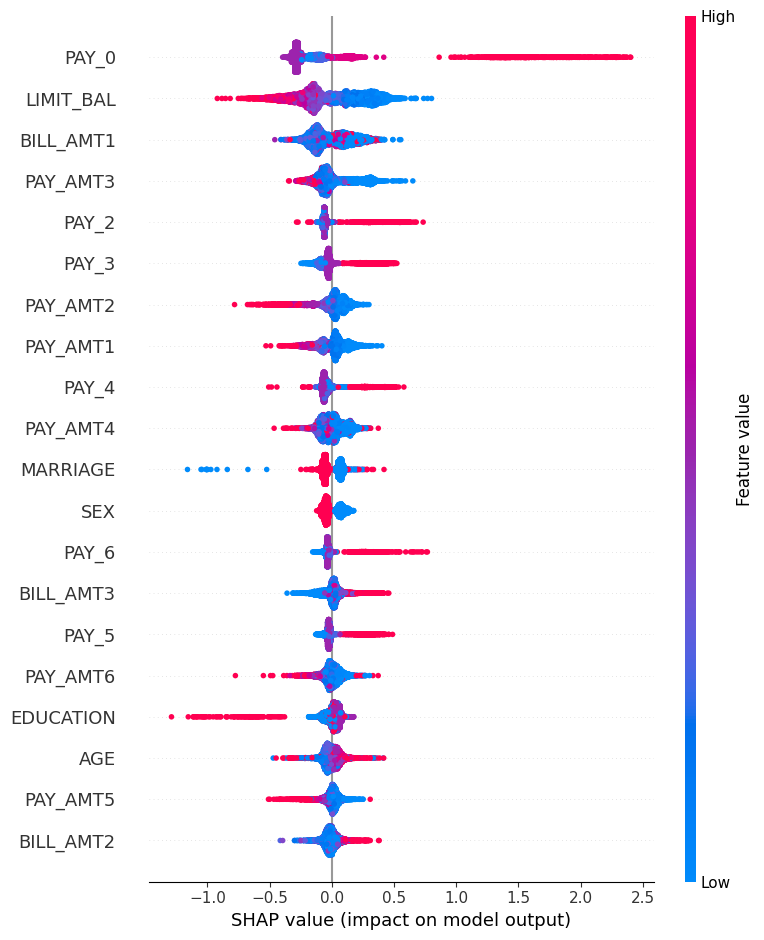

In [49]:
shap.summary_plot(shap_values, X_test)

**Interpretation:** The figure shows the SHAP global output, where the features are ranked from most to least influential. At the top, PAY_0 (the most recent repayment status) has the strongest effect: high values (shown in red, indicating worse repayment behavior) push the prediction toward default, while lower values (blue, indicating timely payments) reduce default risk.

Similarly, LIMIT_BAL, BILL_AMT1, and earlier payment history variables (PAY_2, PAY_3, PAY_AMT1–AMT4) show higher credit limits and lower outstanding bills tend to decrease the predicted probability of default, while higher bills or delayed payments increase it.

Demographic variables such as MARRIAGE, SEX, and EDUCATION appear toward the bottom, indicating relatively weak predictive influence.

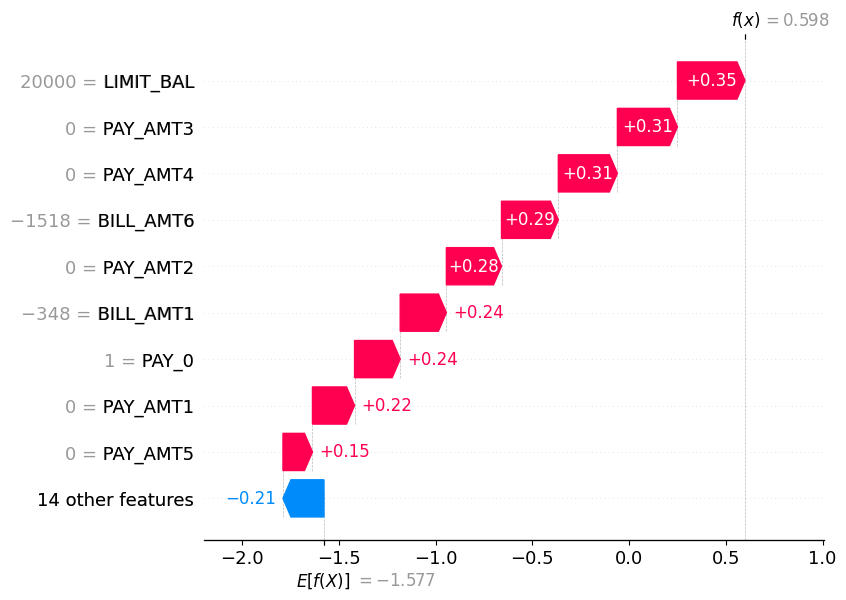

In [50]:
shap.waterfall_plot(
    shap.Explanation(values=shap_values[0],
                     base_values=explainer.expected_value,
                     data=X_test.iloc[0],
                     feature_names=X_test.columns)
)

**Interpretation:** This SHAP waterfall plot provides instance based explanations. The base value represents the average model output, and each step shows how a specific feature pushes the prediction higher (red) or lower (blue). For this customer, variables such as LIMIT_BAL, PAY_AMT3, PAY_AMT4, BILL_AMT6, and PAY_0 all contribute positively, increasing the predicted likelihood of default. Only a small contribution from the group of “14 other features” slightly decreases the prediction.

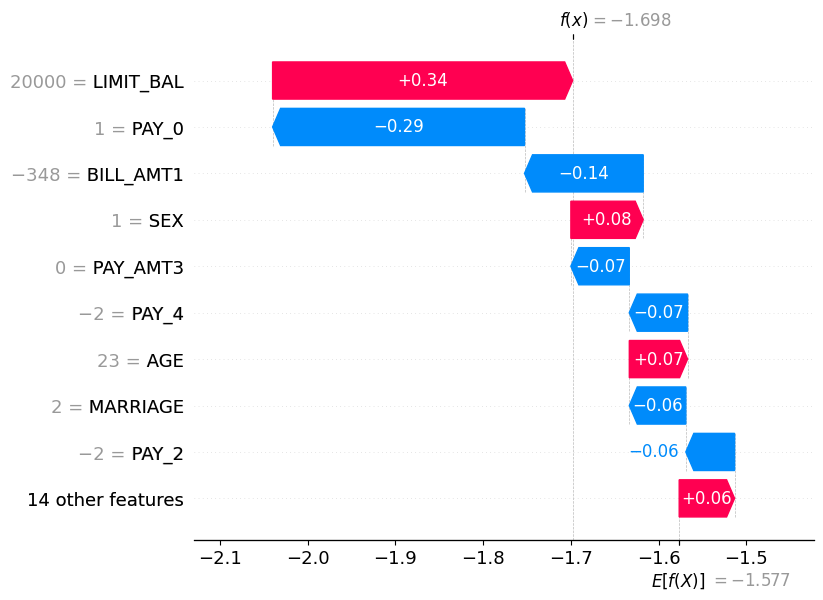

In [51]:
shap.waterfall_plot(
    shap.Explanation(values=shap_values[12],
                     base_values=explainer.expected_value,
                     data=X_test.iloc[0],
                     feature_names=X_test.columns)
)


This plot highlights the important features influencing the prediction for another customer.

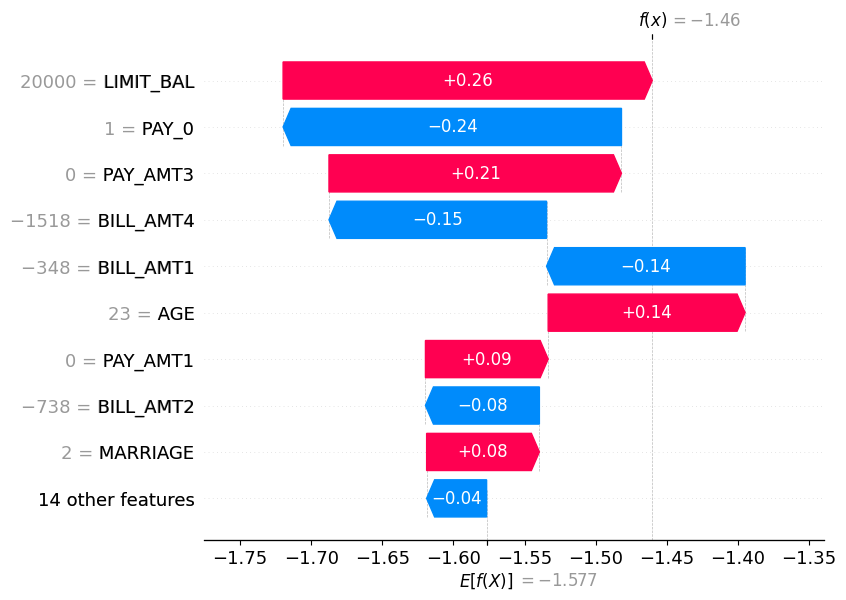

In [52]:
shap.waterfall_plot(
    shap.Explanation(values=shap_values[5],
                     base_values=explainer.expected_value,
                     data=X_test.iloc[0],
                     feature_names=X_test.columns)
)

This plot highlights the important features influencing the prediction for another customer.

## LIME (Local Interpretable Model Agnostic Explanations)

In [53]:
## LIME MODEL

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Default', 'Default'],
    mode='classification'
)

lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[0],
    predict_fn=cat_model.predict_proba
)

lime_exp.show_in_notebook(show_table=True)


/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

Interpretation: Orange bars push the prediction toward default and blue bars push it toward no default. The model assigns greater weight to factors such as PAY_0, LIMIT_BAL, and recent bill amounts, resulting in an overall prediction of a higher likelihood of default (0.65).

In [54]:
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Default', 'Default'],
    mode='classification'
)

lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[5],
    predict_fn=cat_model.predict_proba
)

lime_exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

**Interpetation:** This LIME explanation shows that the model predicts a low probability of default (0.19%) for this customer. Features such as PAY_0 = 0, PAY_2 = 0, and low recent bill amounts strongly contribute toward No Default, while factors like a high credit limit (LIMIT_BAL = 50,000) and older age push slightly toward Default, but not enough to outweigh the strong indicators of timely payment behavior.

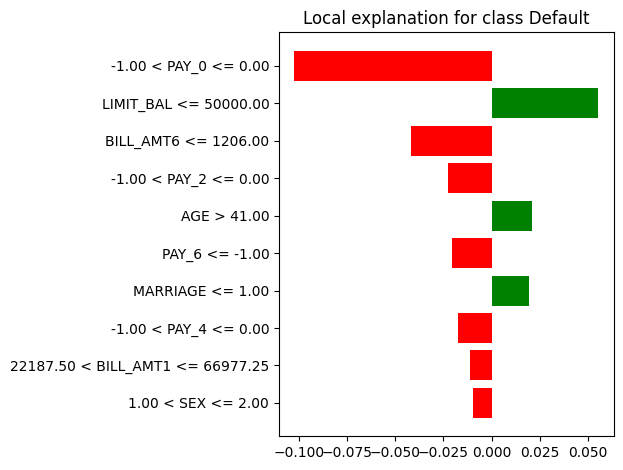

In [55]:
fig = lime_exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

**Interpretation: ** The strongest negative contributions come from recent on-time payments (PAY_0 and PAY_2) and relatively low recent bill amounts, all of which reduce the predicted risk. Only a few factors, such as having a lower credit limit and being older than 41, slightly increase the default probability, but the overall effect still favors a low-risk prediction.

## Permutation Importance

In [56]:
## Permutation Importance

perm = permutation_importance(
    cat_model, X_test, y_test,
    n_repeats=10,
    random_state=199,
    scoring='roc_auc'
)

perm_results = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values(by='importance_mean', ascending=False)

perm_results


feature  importance_mean  importance_std
5       PAY_0         0.080084        0.005142
0   LIMIT_BAL         0.017919        0.002787
11  BILL_AMT1         0.015859        0.002117
6       PAY_2         0.007868        0.002311
12  BILL_AMT2         0.006750        0.001444
17   PAY_AMT1         0.005176        0.001180
7       PAY_3         0.004471        0.001166
20   PAY_AMT4         0.004342        0.001408
13  BILL_AMT3         0.004246        0.000851
15  BILL_AMT5         0.004182        0.000609
18   PAY_AMT2         0.003991        0.001797
19   PAY_AMT3         0.003365        0.001552
10      PAY_6         0.003286        0.000806
14  BILL_AMT4         0.003123        0.001291
9       PAY_5         0.002446        0.000659
22   PAY_AMT6         0.002373        0.000911
8       PAY_4         0.002259        0.001106
2   EDUCATION         0.002018        0.001188
4         AGE         0.001860        0.000736
3    MARRIAGE         0.001175        0.000593
21   PAY_AMT5         0.001123        0.001211
1         SEX         0.000473        0.000552
16  BILL_AMT6         0.000175        0.000685

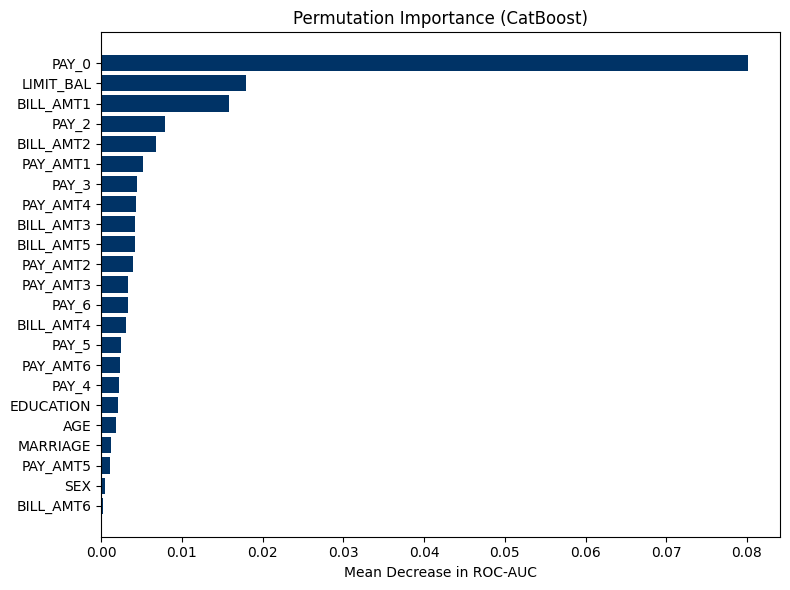

In [57]:
plt.figure(figsize=(8,6))
plt.barh(perm_results['feature'], perm_results['importance_mean'], color="#003366")
plt.gca().invert_yaxis()
plt.title("Permutation Importance (CatBoost)")
plt.xlabel("Mean Decrease in ROC-AUC")
plt.tight_layout()
plt.show()

In [58]:
shap_interactions = explainer.shap_interaction_values(X_test)

<Figure size 800x600 with 0 Axes>

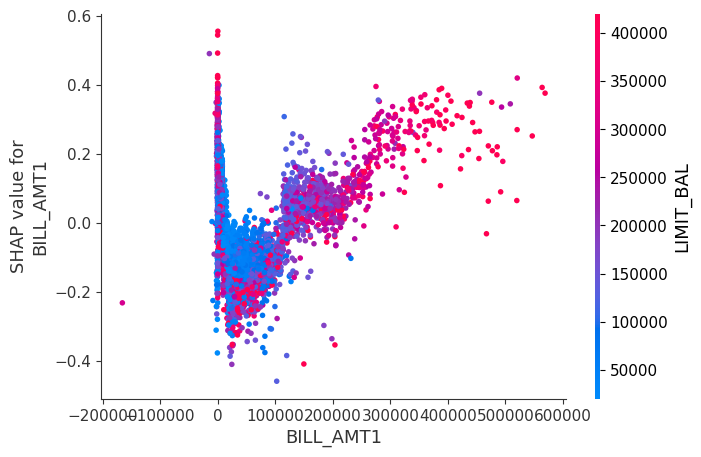

In [59]:
plt.figure(figsize=(8, 6))

shap.dependence_plot(
    "BILL_AMT1",
    shap_values,
    X_test,
    interaction_index="auto"
)

**Interpretation:** This SHAP dependence plot shows how BILL_AMT1 (the first billing amount) influences the model’s prediction, with each point colored by LIMIT_BAL. Higher billing amounts generally correspond to higher SHAP values, meaning the model associates large outstanding bills with a greater likelihood of default. The color gradient reveals that customers with higher credit limits (red points) tend to cluster at higher bill amounts and also exhibit stronger positive contributions to predicted default risk.

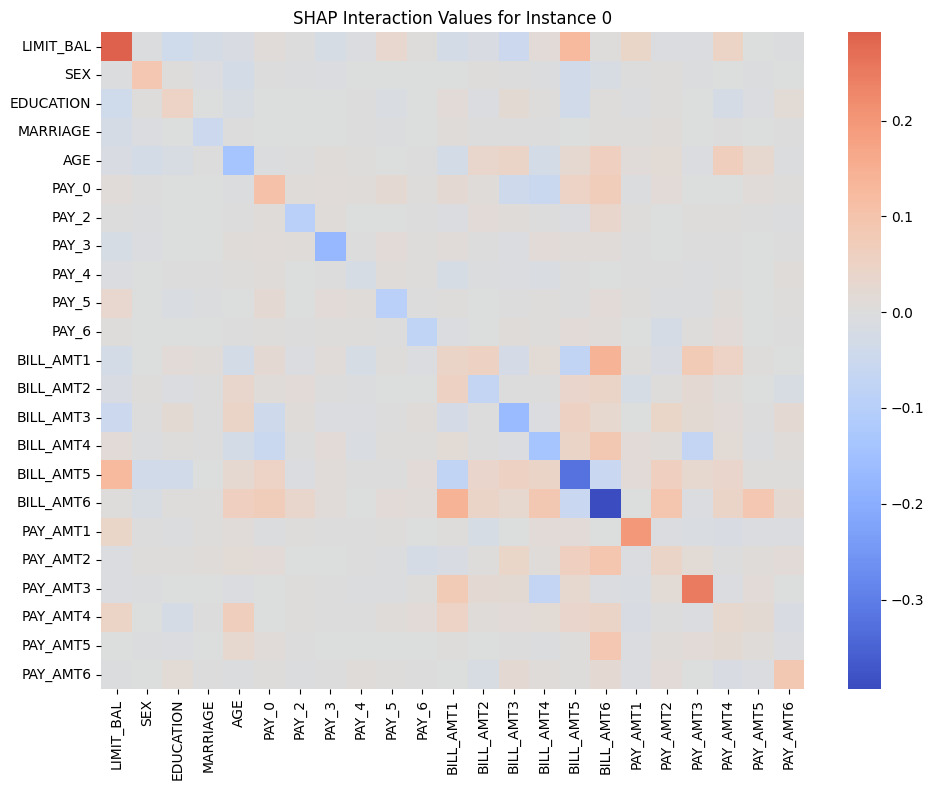

In [60]:
sample = 0
plt.figure(figsize=(10, 8))
sns.heatmap(
    shap_interactions[sample],
    xticklabels=X_test.columns,
    yticklabels=X_test.columns,
    center=0,
    cmap="coolwarm"
)
plt.title("SHAP Interaction Values for Instance 0")
plt.tight_layout()
plt.show()

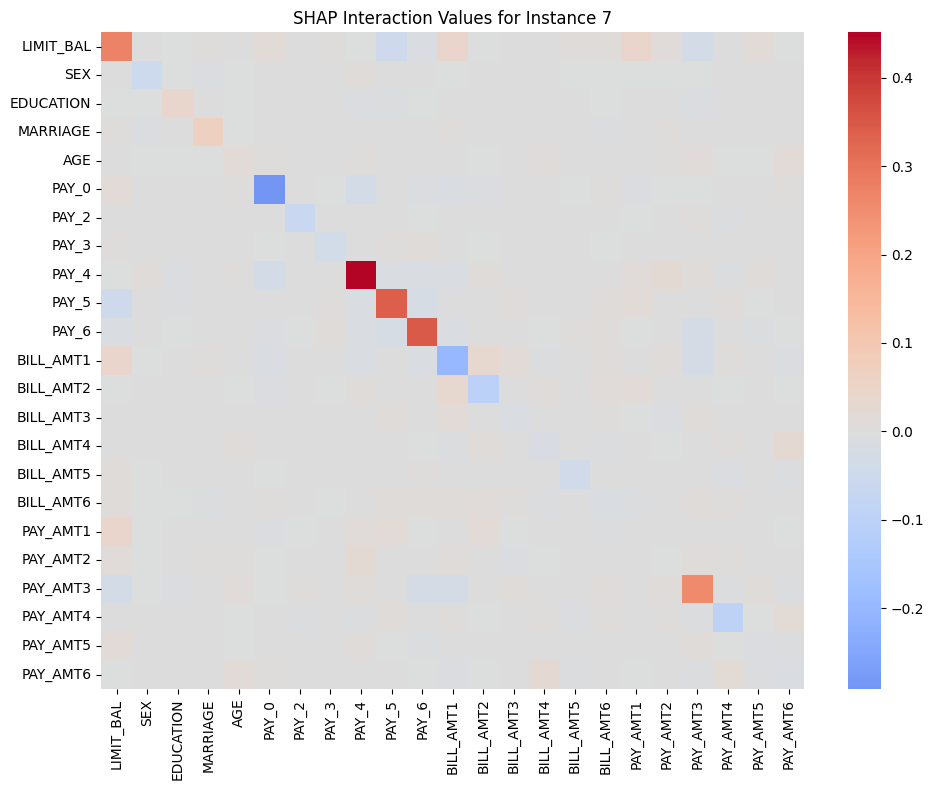

In [61]:
sample = 7
plt.figure(figsize=(10, 8))
sns.heatmap(
    shap_interactions[sample],
    xticklabels=X_test.columns,
    yticklabels=X_test.columns,
    center=0,
    cmap="coolwarm"
)
plt.title("SHAP Interaction Values for Instance 7")
plt.tight_layout()
plt.show()


**Interpretation:** This SHAP interaction heatmap shows how pairs of features jointly influence the model’s prediction for a single customer (Sample 7). Most cells are close to zero, indicating weak or negligible pairwise interactions, meaning the model primarily relies on features independently rather than through strong feature–feature interactions. A few darker regions, such as interactions involving BILL_AMT3, BILL_AMT6, and LIMIT_BAL, show modest interaction effects, suggesting that for this individual, the combined behavior of bill amounts and credit limit slightly amplifies or reduces the predicted probability of default.

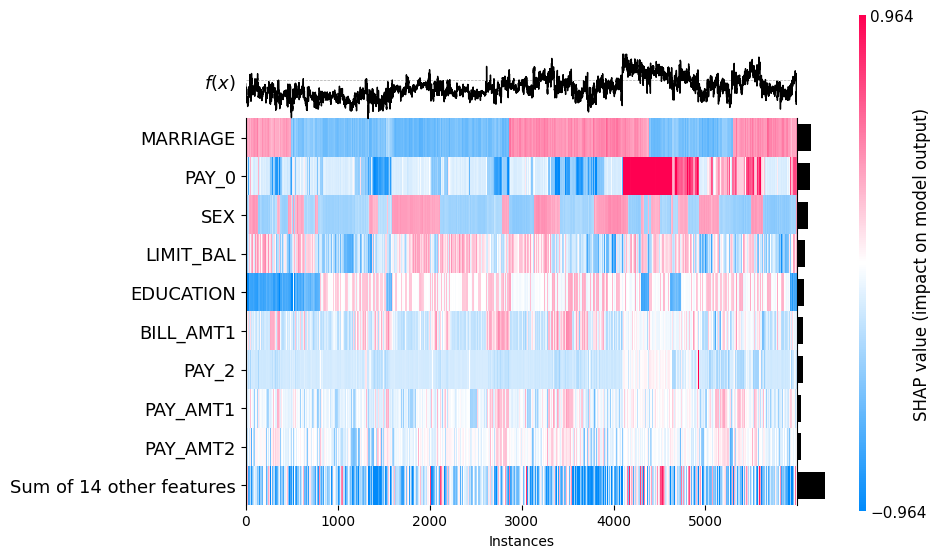

<Axes: xlabel='Instances'>

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)  # returns Explanation object

shap.plots.heatmap(shap_values)


**Interpretation:** The global SHAP summary values show the features such as PAY_0, LIMIT_BAL, and BILL_AMT variables consistently show much higher importance than MARRIAGE. Although MARRIAGE appears at the top of the SHAP decision plot, this does not mean it is the most important predictor.

# Conclusion

Based on the full analysis, a clear pattern emerged about the customers who are more likely to default. Across all models and interpretability techniques, repayment behavior (especially PAY_0 and the other PAY_* variables) consistently showed the strongest influence, suggesting that even small delays in repayment are early warning signals for future default. Financial capacity indicators such as LIMIT_BAL, bill statement amounts (BILL_AMT1–BILL_AMT6), and payment amounts (PAY_AMT1–PAY_AMT6) also played a central role, with lower credit limits, higher and more unstable bill amounts, and irregular or small payments all contributing to an increased risk of default. Demographic factors like AGE, EDUCATION, SEX, and MARRIAGE appeared in the models but had noticeably weaker effects, reinforcing that financial behavior is far more predictive than demographic characteristics. These findings remained stable across Random Forest, XGBoost, LightGBM, CatBoost, RFE, LASSO, Mutual Information, PCA, and SHAP/LIME explanations, which gives confidence in the consistency and validity of the results.

Looking ahead, several next steps could strengthen and extend this analysis.
* Evaluating alternative normalization techniques, such as MinMax scaling in place of StandardScaler, to determine whether different feature scaling strategies improve model performance or stability.
* Hyperparameter tuning for the models: searching over optimized parameter configurations (for example, tree depth, learning rate, number of estimators, regularization strength, or kernel parameters) to improve predictive performance beyond the baseline models included in the current analysis.
* More advanced imbalance-handling techniques, such as Focal Loss, Class Weights, could help increase sensitivity to identifying true defaulters.
* Additional feature engineering may create richer behavioral indicators that go beyond the raw financial variables.
* Incorporating additional explainable AI techniques (e.g., partial dependence plots, individual conditional expectations) to gain deeper insight into feature–outcome relationships and further validate the model’s decision patterns.
* Finally, this work can be further improved by refining and expanding visualizations.